In [2]:
import pandas as pd
import unicodedata
import plotly.express as px

import numpy as np
import itertools
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Funciones

## Países

In [4]:
def _norm(s: str) -> str:
    """Minúsculas, sin tildes, sin espacios extremos."""
    if pd.isna(s):
        return ""
    s = str(s).strip().lower()
    s = ''.join(c for c in unicodedata.normalize('NFKD', s) if not unicodedata.combining(c))
    return s

def _canonical_country(s: str) -> str:
    """Colapsa sinónimos/comunes variantes a una forma canónica."""
    x = _norm(s)

    # Sinónimos frecuentes
    synonyms = {
        # Estados Unidos
        "estados unidos": "united states",
        "eeuu": "united states",
        "eua": "united states",
        "usa": "united states",
        "us": "united states",
        "u.s.": "united states",
        "u.s.a": "united states",

        # México
        "mexico": "mexico",
        "méxico": "mexico",

        # Brasil
        "brasil": "brazil",

        # Países Bajos
        "the netherlands": "netherlands",
        "paises bajos": "netherlands",
        "países bajos": "netherlands",

        # República Dominicana
        "republica dominicana": "dominican republic",

        # Reino Unido (por si aparece)
        "uk": "united kingdom",
        "u.k.": "united kingdom",
        "england": "united kingdom",
        "scotland": "united kingdom",
        "wales": "united kingdom",
        "northern ireland": "united kingdom",

        # España (variantes con tilde)
        "espana": "spain",
        "españa": "spain",

        # Otros posibles en español
        "alemania": "germany",
        "francia": "france",
        "austria": "austria",
        "dinamarca": "denmark",
        "luxemburgo": "luxembourg",
        "guayana": "guyana",
        "surinam": "suriname",
        "honduras": "honduras",
        "el salvador": "el salvador",
        "costarica": "costa rica",
        "costa rica": "costa rica",
        "belice": "belize",
        "japon": "japan",
        "corea del sur": "south korea",
        "corea del norte": "north korea",
    }

    if x in synonyms:
        return synonyms[x]
    return x

In [6]:
NORTH_AMERICA = {
    "canada", "united states", "mexico"
}

CENTRAL_AMERICA = {
    "belize", "guatemala", "honduras", "el salvador", "nicaragua",
    "costa rica", "panama"
}

CARIBBEAN = {
    "cuba", "dominican republic", "haiti", "jamaica", "trinidad and tobago",
    "barbados", "bahamas", "puerto rico"
}

SOUTH_AMERICA = {
    "argentina", "bolivia", "brazil", "chile", "colombia", "ecuador",
    "guyana", "paraguay", "peru", "suriname", "uruguay", "venezuela"
}

EUROPE = {
    "spain", "france", "germany", "austria", "denmark", "luxembourg",
    "netherlands", "portugal", "italy", "sweden", "norway", "finland",
    "switzerland", "ireland", "belgium", "poland", "czech republic",
    "slovakia", "hungary", "romania", "bulgaria", "greece", "croatia",
    "slovenia", "serbia", "bosnia and herzegovina", "montenegro",
    "north macedonia", "albania", "estonia", "latvia", "lithuania",
    "iceland", "united kingdom", "netherlands"
}

ASIA = {
    "china", "japan", "south korea", "north korea", "india", "indonesia",
    "malaysia", "singapore", "thailand", "vietnam", "philippines",
    "taiwan", "hong kong", "pakistan", "bangladesh", "sri lanka",
    "nepal", "cambodia", "laos", "myanmar", "brunei", "mongolia",
    "saudi arabia", "united arab emirates", "qatar", "kuwait", "bahrain",
    "oman", "iran", "iraq", "israel", "jordan", "lebanon", "turkey"
}

AFRICA = {
    "south africa", "egypt", "morocco", "algeria", "tunisia", "kenya",
    "ethiopia", "nigeria", "ghana", "ivory coast", "senegal", "tanzania",
    "uganda", "angola"
}

OCEANIA = {
    "australia", "new zealand"
}

In [8]:
def country_to_zone(country: str) -> str:
    c = _canonical_country(country)

    if c in NORTH_AMERICA:
        return "Norteamérica"
    if c in CENTRAL_AMERICA:
        return "Centroamérica"
    if c in CARIBBEAN:
        return "Caribe"
    if c in SOUTH_AMERICA:
        return "Sudamérica"
    if c in EUROPE:
        return "Europa"
    if c in ASIA:
        return "Asia"
    if c in AFRICA:
        return "África"
    if c in OCEANIA:
        return "Oceanía"

    # Si no está en nuestras listas:
    if c == "" or c == "nan":
        return "Desconocido"
    return "Otra"


In [10]:
CONE_SUR = {"argentina", "chile", "uruguay", "paraguay", "brazil"}
ANDINA = {"colombia", "peru", "ecuador", "bolivia", "venezuela"}

def country_to_zone_split(country: str) -> str:
    c = _canonical_country(country)

    if c in NORTH_AMERICA:
        return "Norteamérica"
    if c in CENTRAL_AMERICA:
        return "Centroamérica"
    if c in CARIBBEAN:
        return "Caribe"
    if c in EUROPE:
        return "Europa"
    if c in ASIA:
        return "Asia"
    if c in AFRICA:
        return "África"
    if c in OCEANIA:
        return "Oceanía"
    
    
    if c in CONE_SUR:
        return "Sudamérica - Cono Sur"
    if c in ANDINA:
        return "Sudamérica - Andina"

    if c == "" or c == "nan":
        return "Desconocido"
    return "Otra"

##  Co-relación

In [12]:
def cramers_v_bias_corrected(x, y):
    """
    Cramér's V con corrección por sesgo (Bergsma 2013).
    Retorna un valor en [0,1]. Maneja NA eliminando filas con NA en x|y.
    """
    # Subconjunto sin NA en x o y
    mask = (~pd.isna(x)) & (~pd.isna(y))
    x = x[mask]
    y = y[mask]
    if x.empty or y.empty:
        return np.nan

    # Tabla de contingencia
    confusion = pd.crosstab(x, y)
    if confusion.size == 0 or confusion.shape[0] < 2 or confusion.shape[1] < 2:
        # Si una de las variables tiene 1 sola categoría no hay varianza
        return 0.0

    chi2, p, dof, expected = chi2_contingency(confusion, correction=False)
    n = confusion.values.sum()

    # Phi2 y corrección por sesgo
    phi2 = chi2 / n
    r, k = confusion.shape

    # Correcciones (Bergsma)
    phi2_corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    r_corr = r - ((r-1)**2) / (n-1)
    k_corr = k - ((k-1)**2) / (n-1)

    denom = min((k_corr-1), (r_corr-1))
    if denom <= 0:
        return 0.0
    v = np.sqrt(phi2_corr / denom)
    # Cerrar a [0,1]
    return float(max(0.0, min(1.0, v)))


def cramers_v_matrix(df, columns):
    """
    Matriz simétrica de Cramér's V para 'columns'.
    """
    cols = list(columns)
    m = pd.DataFrame(np.ones((len(cols), len(cols))), index=cols, columns=cols, dtype=float)
    for i, j in itertools.combinations(range(len(cols)), 2):
        v = cramers_v_bias_corrected(df[cols[i]], df[cols[j]])
        m.iloc[i, j] = v
        m.iloc[j, i] = v
    return m

In [14]:
def plot_heatmap(mat, title="Correlación (Cramér's V) entre categóricas"):
    fig, ax = plt.subplots(figsize=(max(8, len(mat)*0.6), max(6, len(mat)*0.6)))
    cax = ax.imshow(mat.values, vmin=0, vmax=1)
    ax.set_title(title)
    ax.set_xticks(range(len(mat.columns)))
    ax.set_yticks(range(len(mat.index)))
    ax.set_xticklabels(mat.columns, rotation=90)
    ax.set_yticklabels(mat.index)
    fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    plt.show()

In [16]:
def reduce_categorical_set_by_threshold(corr_mat, threshold=0.70):
    """
    Dada una matriz de Cramér's V (DataFrame) y un umbral,
    elimina variables de forma greedy mientras haya pares > umbral.

    Heurística:
    - Detectar el par con mayor V > umbral.
    - Calcular la correlación media de cada variable (con el resto).
    - Eliminar la variable con MAYOR correlación media (la más redundante).
    - Recalcular hasta que no queden pares > umbral.

    Devuelve:
        kept_vars (list), dropped_vars (list)
    """
    working = corr_mat.copy()
    vars_left = list(working.columns)
    dropped = []

    while True:
        # Encontrar el par con mayor correlación (fuera de diagonal)
        mat = working.values.copy()
        np.fill_diagonal(mat, -1.0)
        max_idx = np.unravel_index(np.argmax(mat), mat.shape)
        max_val = mat[max_idx]
        if max_val <= threshold:
            break

        i, j = max_idx
        vi = working.columns[i]
        vj = working.columns[j]

        # Correlación media de cada variable
        mean_i = (working.loc[vi].drop(vi).mean())
        mean_j = (working.loc[vj].drop(vj).mean())

        # Decisión: eliminar la más "redundante"
        to_drop = vi if mean_i >= mean_j else vj
        dropped.append(to_drop)

        # Quitar columna/fila y continuar
        working = working.drop(index=to_drop, columns=to_drop)
        vars_left = [c for c in vars_left if c != to_drop]

        # Si queda 1 o 0, paramos
        if len(vars_left) <= 1:
            break

    return vars_left, dropped

# Limpieza datos

In [19]:
df = pd.read_csv("encuesta_limpia.csv")
df = df.drop(columns = "Unnamed: 0")

In [21]:
df = df.drop(columns= ['PC1', 'PC2', 'cluster'])

In [23]:
df["country_zone"] = df["country"].map(country_to_zone_split)
df["country_education_zone"] = df["country_education"].map(country_to_zone_split)

In [25]:
#df.to_csv("encuesta_por_zona.csv" , index = False)

In [27]:
df.columns

Index(['age', 'gender', 'country', 'city', 'country_education',
       'living_abroad', 'outside_latam', 'category_studies',
       'graduate_studies', 'expertise', 'sector', 'job_position', 'experience',
       '1.1. Awareness of the needs of others', '1.2. Integrity',
       '1.3. Continuous learning', '1.4. Effective communication',
       '1.5. Interpersonal skills', '1.6. Creativity',
       '1.7. Personal emerging skills',
       '2.1. Math, statistics, and analytical thinking',
       '2.2. Reading and writing for comprehension',
       '2.3. Applied science and technology', '2.4. Supply chain fundamentals',
       '2.5. Foundations of business management',
       '2.6. Operations and enterprise economics',
       '2.7. Sustainability and resilience', '2.8. Digital SCM&L',
       '3.1. Problem-solving and decision-making', '3.2. Teamwork',
       '3.3. Accountability and responsibility', '3.4. Customer focus',
       '3.5. Planning and organizing', '3.6. Conflict management',
  

# Exploración

# Análisis

## Co-relación de variables

In [31]:
cat_vars = ['age', 'gender', 'country', 'city', 'country_education',
            'living_abroad', 'outside_latam', 'category_studies',
            'graduate_studies', 'expertise', 'sector', 'job_position', 'experience',
            'country_zone', 'country_education_zone']

In [33]:
exclude_vars = {'personal_skills', 'technical_skills', 'teamwork_skills'}
cat_vars = [c for c in cat_vars if c in df.columns and c not in exclude_vars]

In [35]:
for c in cat_vars:
    df[c] = df[c].astype('category')

In [37]:
THRESH = 0.70  

corr0 = cramers_v_matrix(df, cat_vars)

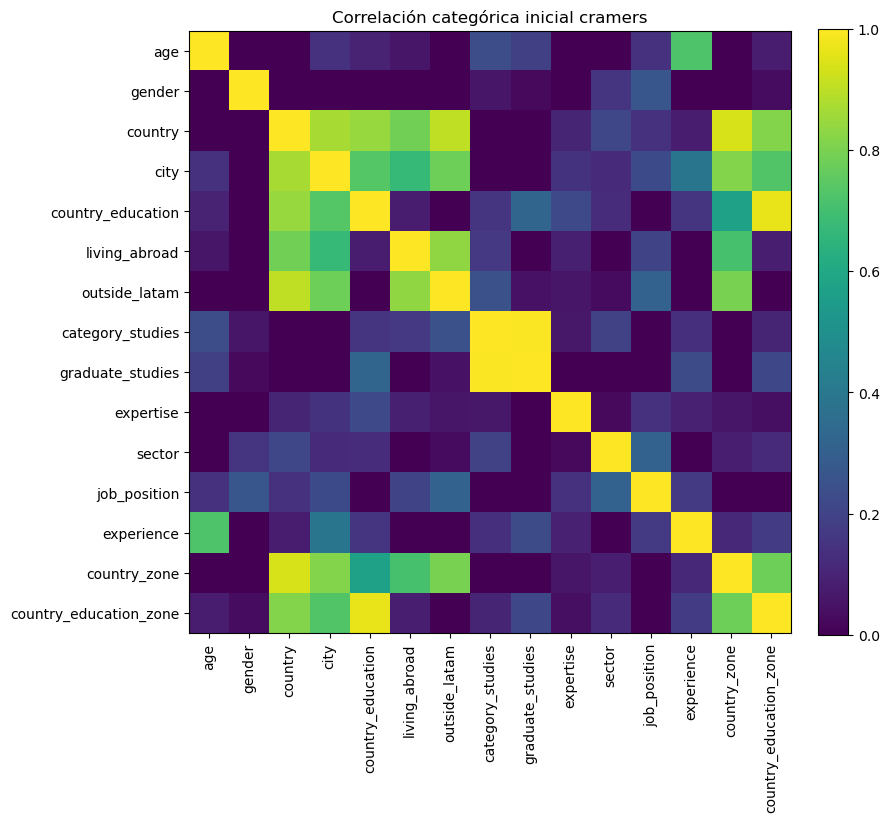

In [38]:
plot_heatmap(corr0, title=f"Correlación categórica inicial cramers")

In [41]:
# Reducción
kept, dropped = reduce_categorical_set_by_threshold(corr0, threshold=THRESH)

In [43]:
print("Variables mantenidas:", kept)
print("Variables descartadas por alta correlación (> {:.2f}):".format(THRESH), dropped)

Variables mantenidas: ['age', 'gender', 'living_abroad', 'graduate_studies', 'expertise', 'sector', 'job_position', 'country_education_zone']
Variables descartadas por alta correlación (> 0.70): ['category_studies', 'country_education', 'country', 'outside_latam', 'city', 'country_zone', 'experience']


In [45]:
corr_final = corr0.loc[kept, kept]

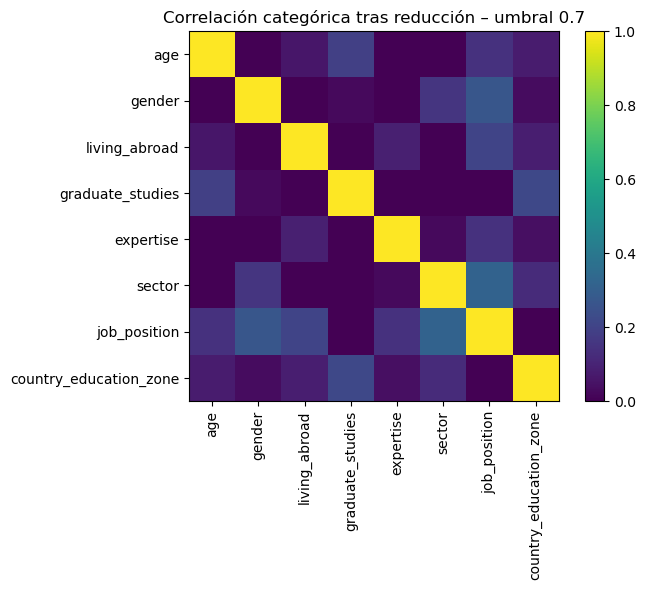

In [47]:
plot_heatmap(corr_final, title=f"Correlación categórica tras reducción – umbral {THRESH}")

In [49]:
df_reducido = df[kept].copy()

## Clusters

In [51]:
cat_keep = [
    "age", "gender", "living_abroad", "graduate_studies",
    "expertise", "sector", "job_position", "country_education_zone"
]

num_cols = df.select_dtypes(include=["number"]).columns.tolist()

cols_final = cat_keep + num_cols

cols_final = [c for c in cols_final if c in df.columns]

df_mixed = df[cols_final].copy()

In [53]:
df_mixed.to_csv("df_mixed.csv" , index = False)

In [55]:
df_mixed

,age,gender,living_abroad,graduate_studies,expertise,sector,job_position,country_education_zone,1.1. Awareness of the needs of others,1.2. Integrity,...,3.2. Teamwork,3.3. Accountability and responsibility,3.4. Customer focus,3.5. Planning and organizing,3.6. Conflict management,3.7. E-business and enabling technology,3.8. Continuity and contingency planning,personal_skills,technical_skills,teamwork_skills
0,3.0,0.0,0.0,1.0,2.0,3.0,Latam supply chain manager,Sudamérica - Cono Sur,4.0,5.0,...,4.0,5.0,4.0,4.0,4.0,3.0,3.0,3.857143,3.750,3.875
1,3.0,1.0,0.0,1.0,2.0,3.0,Supply Chain Executive Manager,Sudamérica - Cono Sur,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.571429,4.250,4.750
2,3.0,1.0,1.0,1.0,2.0,3.0,Finance Director,Sudamérica - Cono Sur,5.0,5.0,...,3.0,4.0,4.0,4.0,3.0,3.0,4.0,4.571429,3.750,3.625
3,3.0,1.0,0.0,1.0,2.0,3.0,South America Supply Chain Director,Sudamérica - Cono Sur,4.0,5.0,...,5.0,5.0,4.0,3.0,4.0,3.0,3.0,4.285714,3.625,3.875
4,3.0,1.0,0.0,1.0,3.0,3.0,Director of Supply Chain,Sudamérica - Cono Sur,4.0,4.0,...,4.0,4.0,3.0,4.0,3.0,3.0,3.0,3.857143,3.625,3.625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,2.0,1.0,0.0,1.0,4.0,3.0,Business Intelligence & Strategy Manager,Norteamérica,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.000000,4.750,5.000
145,3.0,0.0,1.0,1.0,2.0,3.0,NEW BUSINESS DEVELOPMENT AND KEY ACCOUNT MANAGER,Sudamérica - Cono Sur,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.000000,4.875,4.875
146,3.0,0.0,0.0,1.0,3.0,3.0,Strategy and business intelligence Manager,Sudamérica - Cono Sur,5.0,5.0,...,4.0,5.0,3.0,5.0,4.0,3.0,3.0,4.285714,3.750,4.000
147,3.0,1.0,0.0,1.0,3.0,3.0,Head of Supply Chain Operations,Sudamérica - Andina,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.000000,4.125,5.000


In [57]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
cat_cols = ["age","gender","living_abroad","graduate_studies",
            "expertise","sector","job_position","country_education_zone"]
num_cols = df_mixed.select_dtypes(include="number").columns.tolist()

In [61]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

In [63]:
X = preprocessor.fit_transform(df_mixed)

inertias = []
silhouettes = []
K_range = range(2, 8)   # prueba de 2 a 7 clusters

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X, labels))

C:\Users\carlo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\carlo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\carlo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\carlo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

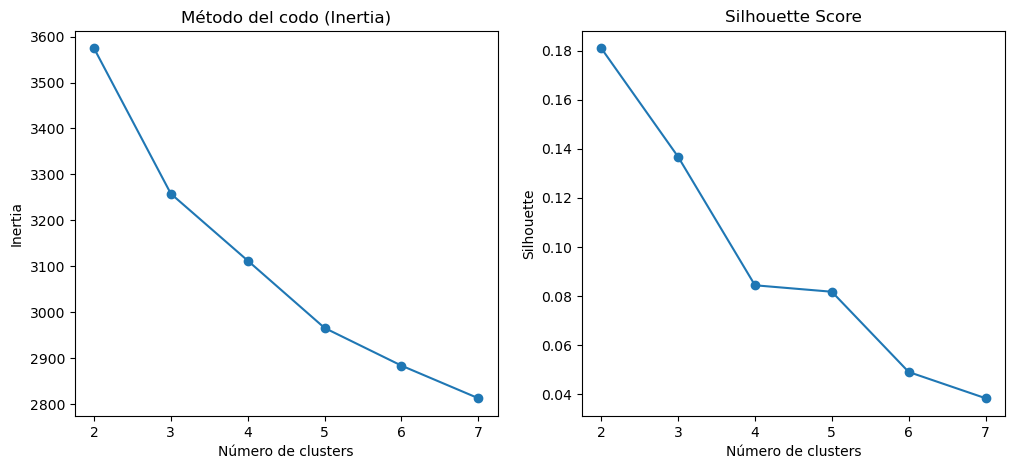

In [65]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].plot(K_range, inertias, marker="o")
ax[0].set_title("Método del codo (Inertia)")
ax[0].set_xlabel("Número de clusters")
ax[0].set_ylabel("Inertia")

ax[1].plot(K_range, silhouettes, marker="o")
ax[1].set_title("Silhouette Score")
ax[1].set_xlabel("Número de clusters")
ax[1].set_ylabel("Silhouette")

plt.show()

In [66]:
k_opt = 5
kmeans_final = KMeans(n_clusters=k_opt, random_state=42)
df_mixed["cluster"] = kmeans_final.fit_predict(X)

print(df_mixed["cluster"].value_counts())

cluster
3    46
1    42
0    33
4    25
2     3
Name: count, dtype: int64


C:\Users\carlo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


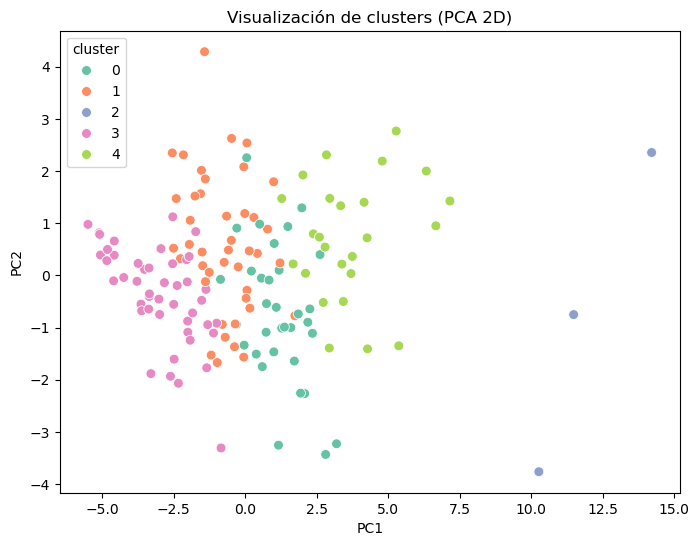

In [69]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray() if hasattr(X, "toarray") else X)

df_plot = pd.DataFrame(X_pca, columns=["PC1","PC2"])
df_plot["cluster"] = df_mixed["cluster"]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_plot, x="PC1", y="PC2", hue="cluster", palette="Set2", s=50)
plt.title("Visualización de clusters (PCA 2D)")
plt.show()

In [71]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

cat_cols = ["age","gender","living_abroad","graduate_studies",
            "expertise","sector","job_position","country_education_zone"]

# Columnas numéricas
num_cols = df_mixed.select_dtypes(include="number").columns.tolist()

# Skills
skills = ["personal_skills","technical_skills","teamwork_skills"]
skills_present = [c for c in skills if c in df_mixed.columns]

In [73]:
num_all = num_cols.copy()

# (b) Sin skills
num_no_skills = [c for c in num_cols if c not in skills_present]

# (c) Solo skills
num_only_skills = skills_present

In [75]:
def make_clusters(df, cat_cols, num_cols, k=3, name="cluster"):
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
        ]
    )
    X = preprocessor.fit_transform(df)
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X)
    df[name] = labels

    # Visualización rápida con PCA 2D
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X.toarray() if hasattr(X,"toarray") else X)
    df_plot = pd.DataFrame(X_pca, columns=["PC1","PC2"])
    df_plot[name] = labels

    plt.figure(figsize=(7,5))
    sns.scatterplot(data=df_plot, x="PC1", y="PC2", hue=name, palette="Set2", s=50)
    plt.title(f"Visualización de {name} (PCA 2D)")
    plt.show()

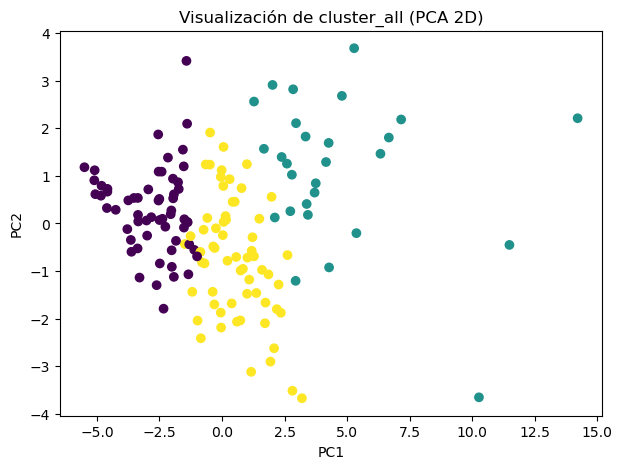

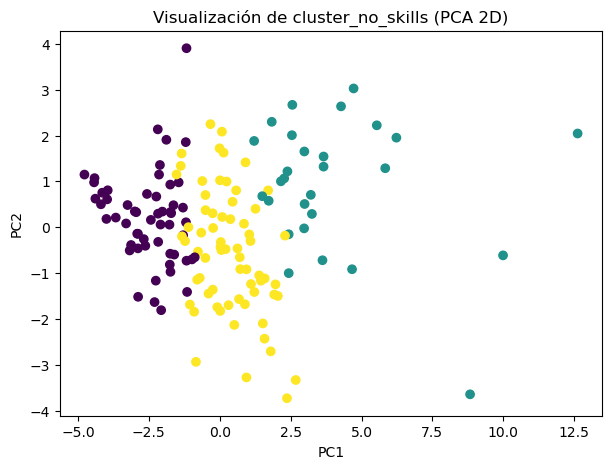

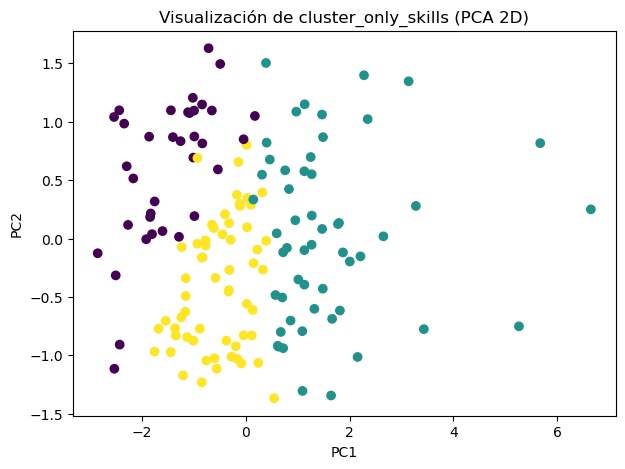


Distribución de clusters:
Con todo:
 cluster_all
2    62
0    59
1    28
Name: count, dtype: int64
Sin skills:
 cluster_no_skills
2    66
0    55
1    28
Name: count, dtype: int64
Solo skills:
 cluster_only_skills
2    60
1    53
0    36
Name: count, dtype: int64


In [77]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# --- Definición de columnas ---
cat_cols = ["age","gender","living_abroad","graduate_studies",
            "expertise","sector","job_position","country_education_zone"]
num_cols = df_mixed.select_dtypes(include="number").columns.tolist()

skills = ["personal_skills","technical_skills","teamwork_skills"]
skills_present = [c for c in skills if c in df_mixed.columns]

num_all = num_cols.copy()
num_no_skills = [c for c in num_cols if c not in skills_present]
num_only_skills = skills_present

def make_clusters(df, cat_cols, num_cols, k=3, name="cluster", plot=True, random_state=42):
    """
    Devuelve (df, model) siempre. En caso de error interno, imprime y devuelve (df, None).
    Maneja casos de listas vacías y NaNs con SimpleImputer.
    """
    try:
        transformers = []

        if len(num_cols) > 0:
            num_pipe = Pipeline([
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler())
            ])
            transformers.append(("num", num_pipe, num_cols))

        if len(cat_cols) > 0:
            cat_pipe = Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore"))
            ])
            transformers.append(("cat", cat_pipe, cat_cols))

        if len(transformers) == 0:
            raise ValueError("No hay columnas numéricas ni categóricas para procesar.")

        preprocessor = ColumnTransformer(transformers=transformers, remainder="drop")

        # Ajuste y transformación
        X = preprocessor.fit_transform(df)

        # KMeans
        model = KMeans(n_clusters=k, n_init="auto", random_state=random_state)
        labels = model.fit_predict(X)
        df[name] = labels

        # Visual (PCA 2D)
        if plot:
            # Convertir a denso si es sparse
            X_dense = X.toarray() if hasattr(X, "toarray") else X
            pca = PCA(n_components=2, random_state=random_state)
            X_pca = pca.fit_transform(X_dense)
            plt.figure(figsize=(7,5))
            scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=labels)
            plt.title(f"Visualización de {name} (PCA 2D)")
            plt.xlabel("PC1")
            plt.ylabel("PC2")
            plt.show()

        return df, model

    except Exception as e:
        print(f"[make_clusters:{name}] Error:", e)
        return df, None

# ------- Ejecutar las tres variantes (ajusta k si quieres) -------
k = 3

df_mixed, model_all         = make_clusters(df_mixed, cat_cols, num_all,         k=k, name="cluster_all")
df_mixed, model_no_skills   = make_clusters(df_mixed, cat_cols, num_no_skills,   k=k, name="cluster_no_skills")
df_mixed, model_only_skills = make_clusters(df_mixed, cat_cols, num_only_skills, k=k, name="cluster_only_skills")

print("\nDistribución de clusters:")
if "cluster_all" in df_mixed:         print("Con todo:\n", df_mixed["cluster_all"].value_counts())
if "cluster_no_skills" in df_mixed:   print("Sin skills:\n", df_mixed["cluster_no_skills"].value_counts())
if "cluster_only_skills" in df_mixed: print("Solo skills:\n", df_mixed["cluster_only_skills"].value_counts())


In [1]:
#Noviembre 4
# Ver diferencia entre all y only_skills
# Analizar las medias de las desviaciones estandar para ver si no se pierde información de las muestras
# Ampliar los skills

## Diferencia entre all y only_skills

In [89]:
#Análisis que no hemos revisado
print("Distribución de cluster_all:")
print(df_mixed["cluster_all"].value_counts(normalize=True).round(2))

print("\nDistribución de cluster_only_skills:")
print(df_mixed["cluster_only_skills"].value_counts(normalize=True).round(2))
#df_mixed

Distribución de cluster_all:
cluster_all
2    0.42
0    0.40
1    0.19
Name: proportion, dtype: float64

Distribución de cluster_only_skills:
cluster_only_skills
2    0.40
1    0.36
0    0.24
Name: proportion, dtype: float64


In [91]:
skills_cols = ["personal_skills", "technical_skills", "teamwork_skills"]

mean_all = df_mixed.groupby("cluster_all")[skills_cols].mean()
mean_only = df_mixed.groupby("cluster_only_skills")[skills_cols].mean()

print("Promedios por cluster_all:")
display(mean_all)
print("\nPromedios por cluster_only_skills:")
display(mean_only)


Promedios por cluster_all:


,personal_skills,technical_skills,teamwork_skills
cluster_all,,,
0,4.728814,4.474576,4.690678
1,3.938776,3.459821,3.638393
2,4.313364,3.975806,4.290323



Promedios por cluster_only_skills:


,personal_skills,technical_skills,teamwork_skills
cluster_only_skills,,,
0,4.793651,4.454861,4.722222
1,4.061995,3.587264,3.912736
2,4.480952,4.281250,4.454167


In [93]:
summary_diff = mean_all.mean() - mean_only.mean()
print("Diferencia promedio entre agrupamientos (mean_all - mean_only):")
print(summary_diff)


Diferencia promedio entre agrupamientos (mean_all - mean_only):
personal_skills    -0.118548
technical_skills   -0.137724
teamwork_skills    -0.156577
dtype: float64


In [95]:
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(df_mixed["cluster_all"], df_mixed["cluster_only_skills"])

print("1 = los clusters son prácticamente iguales. \n 0 = no hay relación. \n<0= menos acuerdo del esperado por azar.")
print(f"\nÍndice Rand Ajustado entre cluster_all y cluster_only_skills: {ari:.3f}")

1 = los clusters son prácticamente iguales. 
 0 = no hay relación. 
<0= menos acuerdo del esperado por azar.

Índice Rand Ajustado entre cluster_all y cluster_only_skills: 0.291


In [139]:
#Ampliamos los skills

In [97]:
df_nuevas_skills = df_mixed.copy()


df_nuevas_skills = df_nuevas_skills.drop(columns=["personal_skills", "technical_skills", "teamwork_skills"], errors='ignore')


personal_skills = [
    '1.1. Awareness of the needs of others',
    '1.2. Integrity',
    '1.3. Continuous learning',
    '1.6. Creativity',
    '1.7. Personal emerging skills'
]

communication_skills = [
    '1.4. Effective communication',
    '1.5. Interpersonal skills'
]

analytical_technical_skills = [
    '2.1. Math, statistics, and analytical thinking',
    '2.2. Reading and writing for comprehension',
    '2.3. Applied science and technology',
    '2.4. Supply chain fundamentals',
    '2.5. Foundations of business management',
    '2.6. Operations and enterprise economics',
    '2.7. Sustainability and resilience',
    '2.8. Digital SCM&L'
]

teamwork_leadership_skills = [
    '3.1. Problem-solving and decision-making',
    '3.2. Teamwork',
    '3.3. Accountability and responsibility',
    '3.4. Customer focus',
    '3.5. Planning and organizing',
    '3.6. Conflict management'
]

digital_strategic_skills = [
    '3.7. E-business and enabling technology',
    '3.8. Continuity and contingency planning'
]


df_nuevas_skills["personal_skills"] = df_nuevas_skills[personal_skills].mean(axis=1)
df_nuevas_skills["communication_skills"] = df_nuevas_skills[communication_skills].mean(axis=1)
df_nuevas_skills["analytical_technical_skills"] = df_nuevas_skills[analytical_technical_skills].mean(axis=1)
df_nuevas_skills["teamwork_leadership_skills"] = df_nuevas_skills[teamwork_leadership_skills].mean(axis=1)
df_nuevas_skills["digital_strategic_skills"] = df_nuevas_skills[digital_strategic_skills].mean(axis=1)


df_nuevas_skills["overall_skills"] = df_nuevas_skills[
    ["personal_skills", "communication_skills", "analytical_technical_skills",
     "teamwork_leadership_skills", "digital_strategic_skills"]
].mean(axis=1)

# Mostrar las nuevas columnas creadas
df_nuevas_skills2 = df_nuevas_skills.copy()
df_nuevas_skills[
    ["personal_skills", "communication_skills", "analytical_technical_skills",
     "teamwork_leadership_skills", "digital_strategic_skills", "overall_skills"]
].head()


,personal_skills,communication_skills,analytical_technical_skills,teamwork_leadership_skills,digital_strategic_skills,overall_skills
0,4.0,3.5,3.750,4.166667,3.0,3.683333
1,4.4,5.0,4.250,5.000000,4.0,4.530000
2,4.4,5.0,3.750,3.666667,3.5,4.063333
3,4.4,4.0,3.625,4.166667,3.0,3.838333
4,4.2,3.0,3.625,3.833333,3.0,3.531667


## nuevo cluster

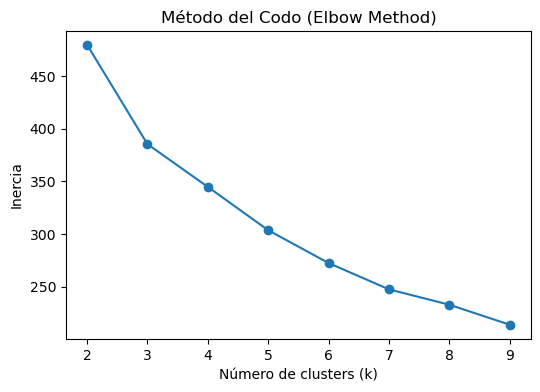

                    personal_skills  communication_skills  \
cluster_new_skills                                          
0                              4.35                  4.45   
1                              4.64                  4.75   
2                              4.01                  3.70   
3                              3.00                  3.50   

                    analytical_technical_skills  teamwork_leadership_skills  \
cluster_new_skills                                                            
0                                          3.99                        4.39   
1                                          4.40                        4.78   
2                                          3.60                        4.05   
3                                          2.25                        2.83   

                    digital_strategic_skills  
cluster_new_skills                            
0                                       3.49  
1                

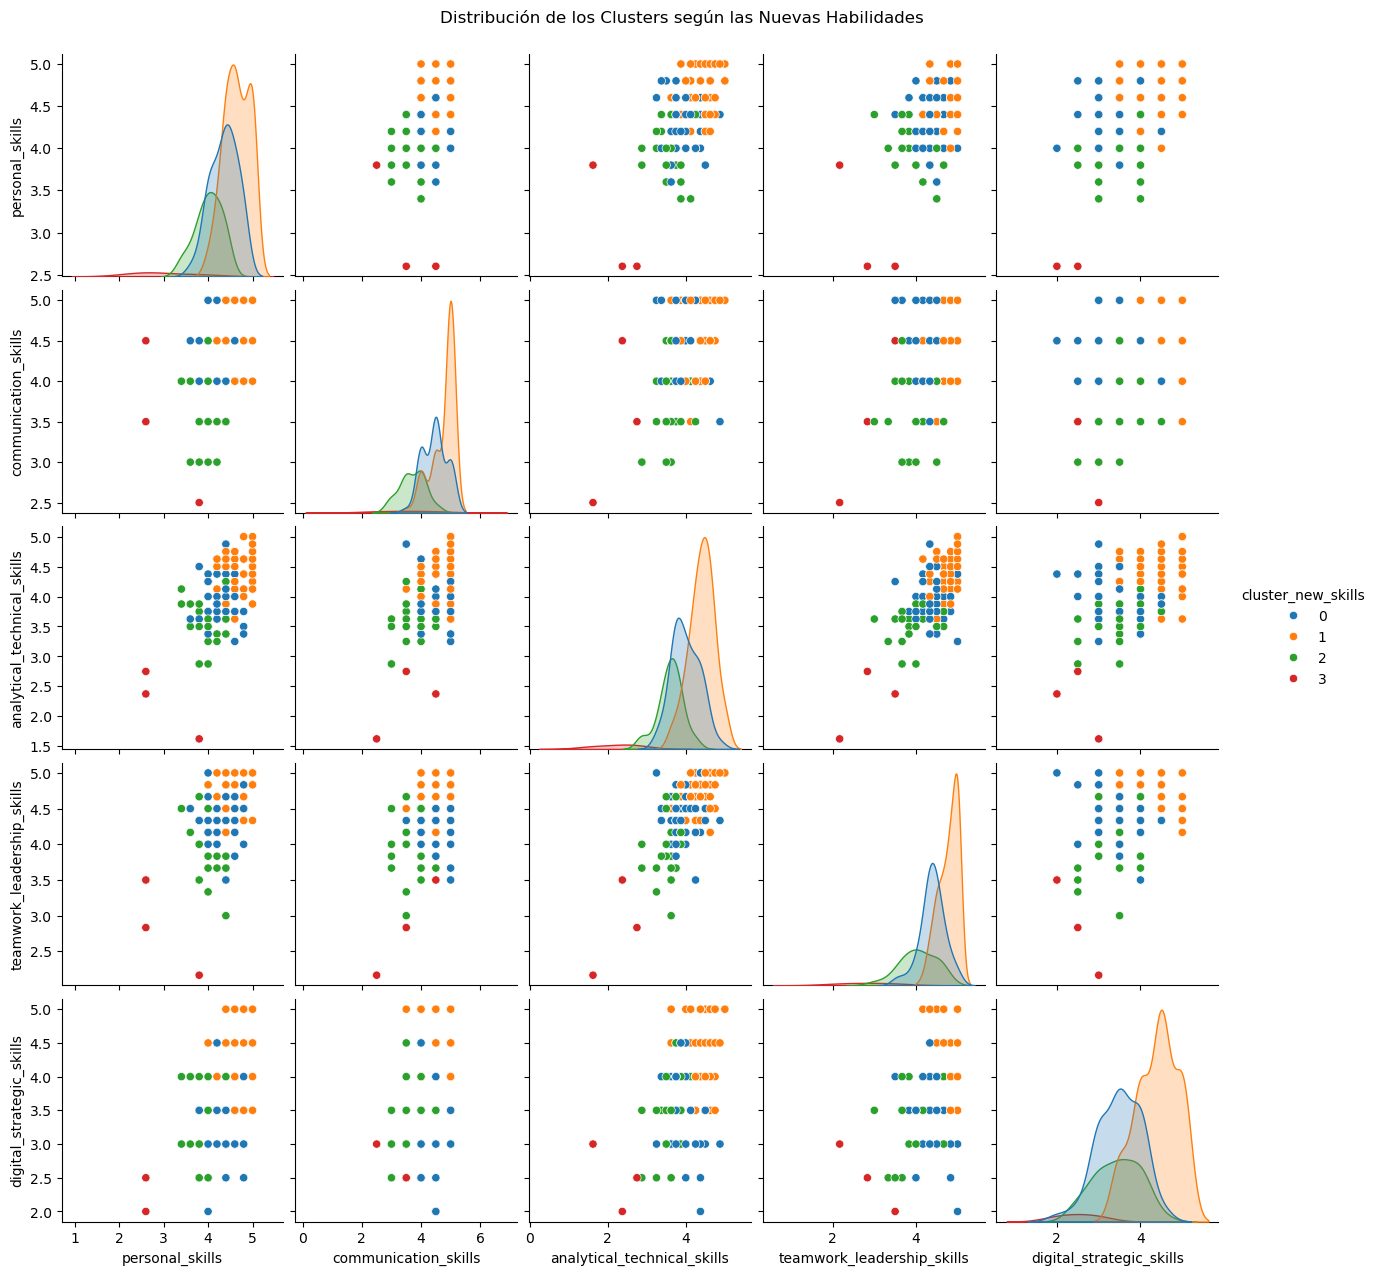

In [99]:
# ==========================
# 1️⃣ Importar librerías
# ==========================
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# 2️⃣ Seleccionar las variables de habilidades
# ==========================
skills_vars = [
    "personal_skills",
    "communication_skills",
    "analytical_technical_skills",
    "teamwork_leadership_skills",
    "digital_strategic_skills"
]

X = df_nuevas_skills[skills_vars]

# ==========================
# 3️⃣ Estandarizar (muy importante para clustering)
# ==========================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ==========================
# 4️⃣ Elegir número óptimo de clusters (método del codo)
# ==========================
inertias = []
K_range = range(2, 10)  # prueba entre 2 y 9 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertias, marker='o')
plt.title('Método del Codo (Elbow Method)')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.show()

# 💡 Observa el gráfico y elige el "codo" (donde se estabiliza la curva).
# Por ejemplo, supongamos que el codo está en k=4

# ==========================
# 5️⃣ Ajustar K-Means con k óptimo
# ==========================
k_optimo = 4  # cambia este valor según el gráfico
kmeans_final = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
df_nuevas_skills["cluster_new_skills"] = kmeans_final.fit_predict(X_scaled)

# ==========================
# 6️⃣ Analizar los resultados
# ==========================
# Promedio de cada cluster por habilidad
cluster_summary = df_nuevas_skills.groupby("cluster_new_skills")[skills_vars].mean().round(2)
print(cluster_summary)

# ==========================
# 7️⃣ Visualización de los clusters
# ==========================
sns.pairplot(df_nuevas_skills, vars=skills_vars, hue="cluster_new_skills", palette="tab10")
plt.suptitle("Distribución de los Clusters según las Nuevas Habilidades", y=1.02)
plt.show()


In [100]:
df_nuevas_skills

,age,gender,living_abroad,graduate_studies,expertise,sector,job_position,country_education_zone,1.1. Awareness of the needs of others,1.2. Integrity,...,cluster_all,cluster_no_skills,cluster_only_skills,personal_skills,communication_skills,analytical_technical_skills,teamwork_leadership_skills,digital_strategic_skills,overall_skills,cluster_new_skills
0,3.0,0.0,0.0,1.0,2.0,3.0,Latam supply chain manager,Sudamérica - Cono Sur,4.0,5.0,...,1,1,1,4.0,3.5,3.750,4.166667,3.0,3.683333,2
1,3.0,1.0,0.0,1.0,2.0,3.0,Supply Chain Executive Manager,Sudamérica - Cono Sur,5.0,5.0,...,0,0,2,4.4,5.0,4.250,5.000000,4.0,4.530000,1
2,3.0,1.0,1.0,1.0,2.0,3.0,Finance Director,Sudamérica - Cono Sur,5.0,5.0,...,1,1,1,4.4,5.0,3.750,3.666667,3.5,4.063333,0
3,3.0,1.0,0.0,1.0,2.0,3.0,South America Supply Chain Director,Sudamérica - Cono Sur,4.0,5.0,...,1,1,1,4.4,4.0,3.625,4.166667,3.0,3.838333,2
4,3.0,1.0,0.0,1.0,3.0,3.0,Director of Supply Chain,Sudamérica - Cono Sur,4.0,4.0,...,1,1,1,4.2,3.0,3.625,3.833333,3.0,3.531667,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,2.0,1.0,0.0,1.0,4.0,3.0,Business Intelligence & Strategy Manager,Norteamérica,5.0,5.0,...,0,0,0,5.0,5.0,4.750,5.000000,5.0,4.950000,1
145,3.0,0.0,1.0,1.0,2.0,3.0,NEW BUSINESS DEVELOPMENT AND KEY ACCOUNT MANAGER,Sudamérica - Cono Sur,5.0,5.0,...,0,0,0,5.0,5.0,4.875,5.000000,4.5,4.875000,1
146,3.0,0.0,0.0,1.0,3.0,3.0,Strategy and business intelligence Manager,Sudamérica - Cono Sur,5.0,5.0,...,2,2,1,4.4,4.0,3.750,4.333333,3.0,3.896667,0
147,3.0,1.0,0.0,1.0,3.0,3.0,Head of Supply Chain Operations,Sudamérica - Andina,5.0,5.0,...,0,0,0,5.0,5.0,4.125,5.000000,5.0,4.825000,1


In [101]:
skills_vars = [
    "personal_skills",
    "communication_skills",
    "analytical_technical_skills",
    "teamwork_leadership_skills",
    "digital_strategic_skills"
]

cluster_summary = df_nuevas_skills.groupby("cluster_new_skills")[skills_vars].mean().round(2)
display(cluster_summary)


,personal_skills,communication_skills,analytical_technical_skills,teamwork_leadership_skills,digital_strategic_skills
cluster_new_skills,,,,,
0,4.35,4.45,3.99,4.39,3.49
1,4.64,4.75,4.40,4.78,4.39
2,4.01,3.70,3.60,4.05,3.44
3,3.00,3.50,2.25,2.83,2.50


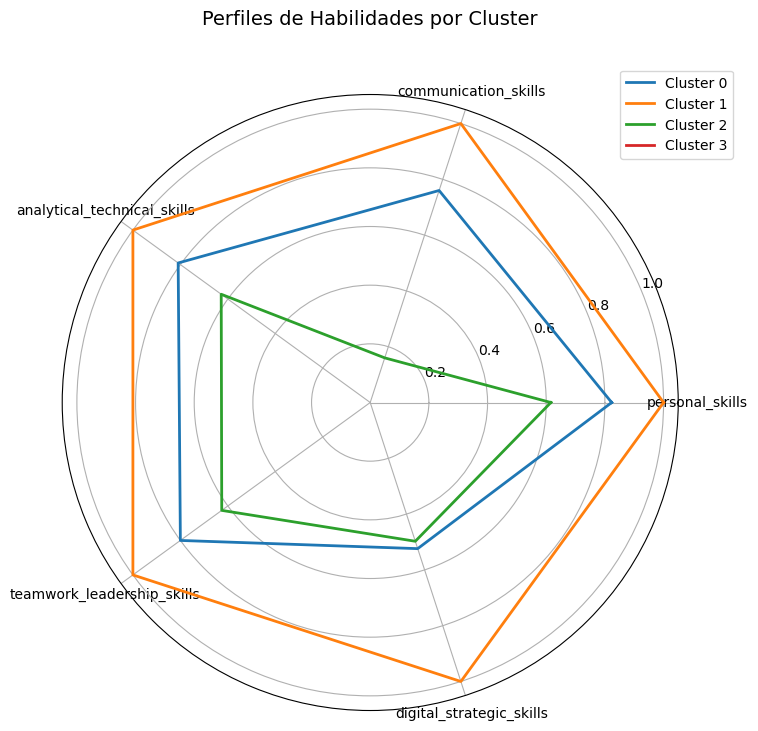

In [183]:
import matplotlib.pyplot as plt
import numpy as np

# Crear el radar chart
categories = skills_vars
N = len(categories)

# Ángulos para el gráfico circular
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # cerrar el círculo

# Normalizar los datos (0–1) para comparar mejor
cluster_norm = (cluster_summary - cluster_summary.min()) / (cluster_summary.max() - cluster_summary.min())

plt.figure(figsize=(8, 8))
for i, row in cluster_norm.iterrows():
    values = row.tolist()
    values += values[:1]
    plt.polar(angles, values, label=f"Cluster {i}", linewidth=2)

plt.xticks(angles[:-1], categories, fontsize=10)
plt.title("Perfiles de Habilidades por Cluster", size=14, y=1.1)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()


In [ ]:
# 4 de noviembre

#Pareciera que la información de los encuestados no está afectando los resultados

#Prueba de hipotesis (puede ser t_student) comparación de medias para evaluar si son diferentes y si son significativas , all y no skills . nuevos clusters
        #Primero validar si son normales o si no, y aplicar la prueba dependiendo de los datos par la prueba de hipótesis, evaluar significancia

#Nuevo análisis: tomar los clusters iniciales plotearlos en un esquema similar a este diagram de radar

#Sin normalizar

In [105]:
df_nuevas_skills.cluster_new_skills.value_counts()

cluster_new_skills
1    69
0    50
2    27
3     3
Name: count, dtype: int64

In [108]:
categorical_vars = [
    "age", "gender", "living_abroad", "graduate_studies",
    "expertise", "sector", "job_position", "country_education_zone"
]

for col in categorical_vars:
    print(f"\n Distribución de {col} por cluster_new_skills:")
    crosstab = pd.crosstab(df_nuevas_skills[col], df_nuevas_skills["cluster_new_skills"], normalize='columns') * 100
    display(crosstab.round(1))



 Distribución de age por cluster_new_skills:


cluster_new_skills,0,1,2,3
age,,,,
2.0,22.0,14.5,7.4,0.0
3.0,74.0,75.4,88.9,100.0
4.0,4.0,10.1,3.7,0.0



 Distribución de gender por cluster_new_skills:


cluster_new_skills,0,1,2,3
gender,,,,
0.0,34.0,37.7,40.7,33.3
1.0,66.0,62.3,59.3,66.7



 Distribución de living_abroad por cluster_new_skills:


cluster_new_skills,0,1,2,3
living_abroad,,,,
0.0,78.0,78.3,63.0,100.0
1.0,22.0,21.7,37.0,0.0



 Distribución de graduate_studies por cluster_new_skills:


cluster_new_skills,0,1,2,3
graduate_studies,,,,
0.0,4.0,4.3,3.7,0.0
1.0,96.0,95.7,96.3,100.0



 Distribución de expertise por cluster_new_skills:


cluster_new_skills,0,1,2,3
expertise,,,,
1.0,10.0,0.0,3.7,0.0
2.0,32.0,39.1,44.4,100.0
3.0,50.0,39.1,37.0,0.0
4.0,8.0,21.7,14.8,0.0



 Distribución de sector por cluster_new_skills:


cluster_new_skills,0,1,2,3
sector,,,,
1.0,4.0,7.2,7.4,0.0
2.0,4.0,4.3,7.4,0.0
3.0,92.0,88.4,85.2,100.0



 Distribución de job_position por cluster_new_skills:


cluster_new_skills,0,1,2,3
job_position,,,,
Account manager,0.0,1.4,0.0,0.0
Advanced Analytics Manager,0.0,1.4,0.0,0.0
Advisor to the Board,0.0,1.4,0.0,0.0
Analytics Engineer Lead,0.0,1.4,0.0,0.0
Assistant Professor,0.0,1.4,0.0,0.0
...,...,...,...,...
Technology Services Manager,0.0,1.4,0.0,0.0
Training and Certification Analyst,2.0,0.0,0.0,0.0
Transportation Manager,0.0,1.4,0.0,0.0



 Distribución de country_education_zone por cluster_new_skills:


cluster_new_skills,0,1,2,3
country_education_zone,,,,
Centroamérica,2.0,2.9,0.0,0.0
Norteamérica,16.0,10.1,14.8,33.3
Sudamérica - Andina,38.0,46.4,29.6,33.3
Sudamérica - Cono Sur,44.0,40.6,55.6,33.3


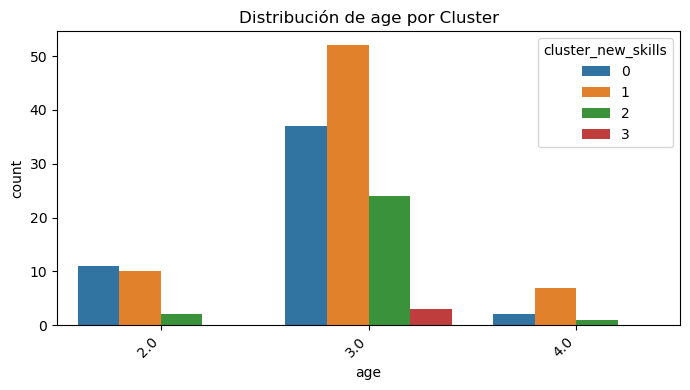

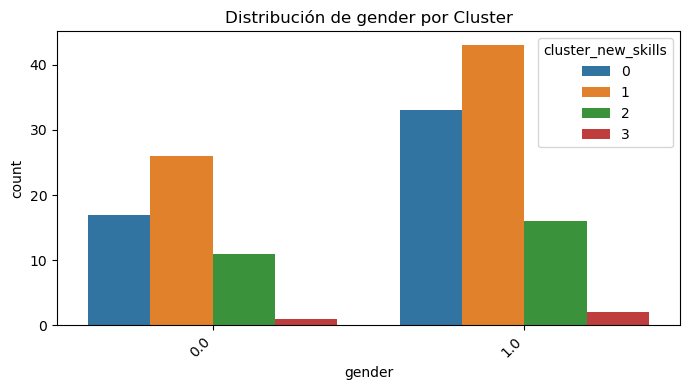

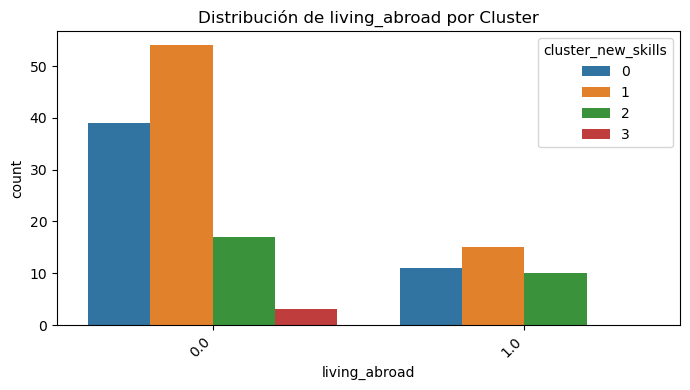

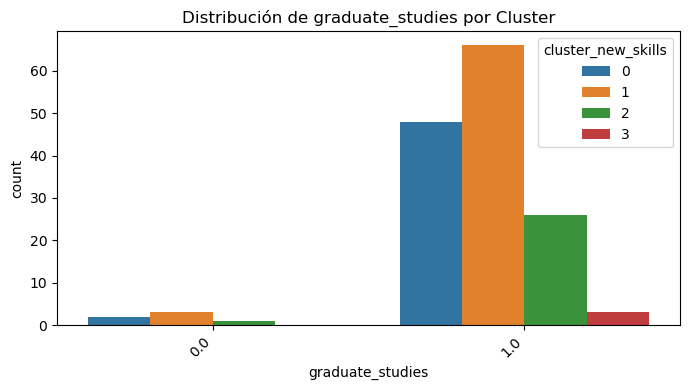

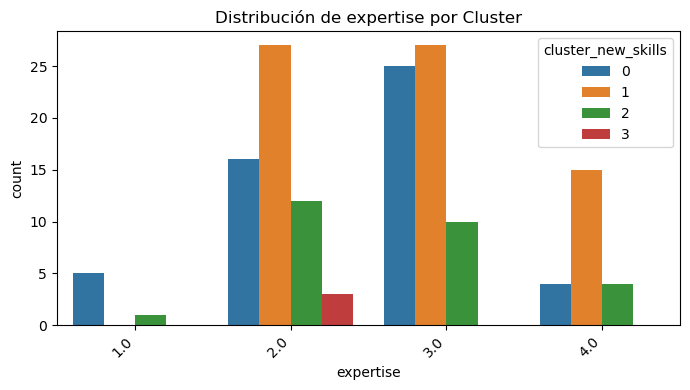

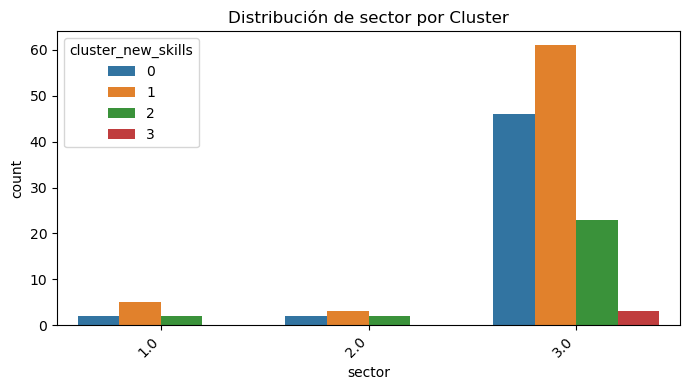

C:\Users\carlo\AppData\Local\Temp\ipykernel_7716\3385836612.py:9: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


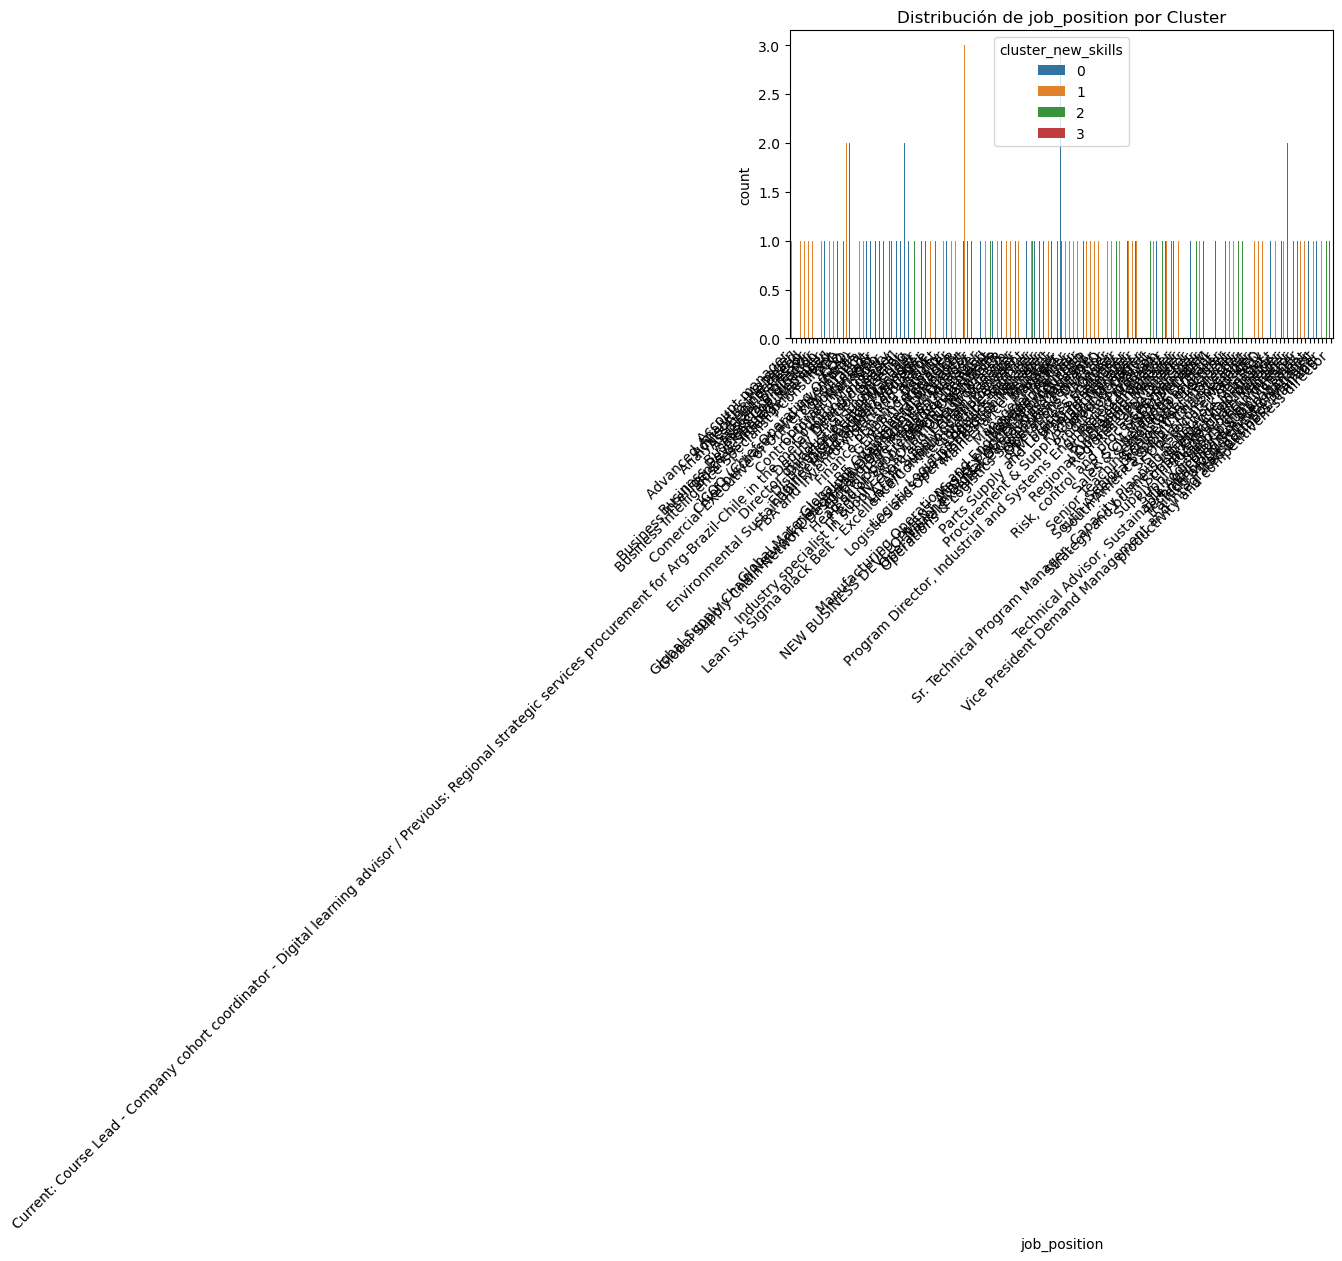

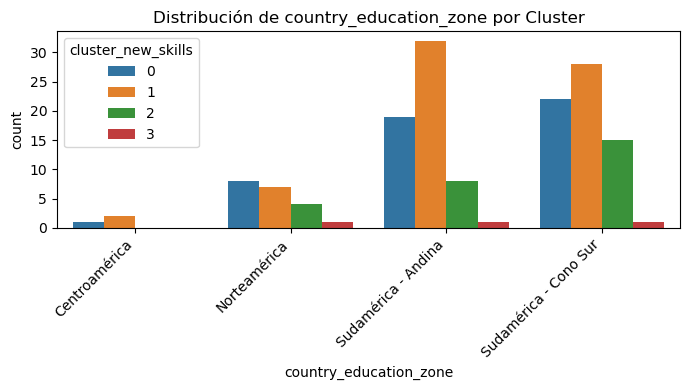

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in categorical_vars:
    plt.figure(figsize=(7,4))
    sns.countplot(data=df_nuevas_skills, x=col, hue="cluster_new_skills", palette="tab10")
    plt.title(f"Distribución de {col} por Cluster")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [111]:
assoc_results = []

for col in categorical_vars:
    contingency = pd.crosstab(df_nuevas_skills[col], df_nuevas_skills["cluster_new_skills"])
    chi2, p, dof, expected = chi2_contingency(contingency)
    assoc_results.append({"Variable": col, "p-value": p})

assoc_df = pd.DataFrame(assoc_results).sort_values("p-value")
display(assoc_df)


,Variable,p-value
4,expertise,0.042700
6,job_position,0.201766
2,living_abroad,0.290108
0,age,0.410691
7,country_education_zone,0.819645
1,gender,0.943107
5,sector,0.956457
3,graduate_studies,0.984988


## Desviación estandar

In [114]:
# Hacer esta tablita con sus desviaciones estándar

df_mixed.groupby("cluster_only_skills")[["personal_skills", "technical_skills", "teamwork_skills"]].mean()

,personal_skills,technical_skills,teamwork_skills
cluster_only_skills,,,
0,4.793651,4.454861,4.722222
1,4.061995,3.587264,3.912736
2,4.480952,4.281250,4.454167


In [116]:
df_mixed.groupby("cluster_only_skills")[["personal_skills", "technical_skills", "teamwork_skills"]].std()


,personal_skills,technical_skills,teamwork_skills
cluster_only_skills,,,
0,0.188424,0.331599,0.223829
1,0.387713,0.445723,0.452414
2,0.232244,0.305862,0.243525


In [118]:
df_mixed

,age,gender,living_abroad,graduate_studies,expertise,sector,job_position,country_education_zone,1.1. Awareness of the needs of others,1.2. Integrity,...,3.6. Conflict management,3.7. E-business and enabling technology,3.8. Continuity and contingency planning,personal_skills,technical_skills,teamwork_skills,cluster,cluster_all,cluster_no_skills,cluster_only_skills
0,3.0,0.0,0.0,1.0,2.0,3.0,Latam supply chain manager,Sudamérica - Cono Sur,4.0,5.0,...,4.0,3.0,3.0,3.857143,3.750,3.875,4,1,1,1
1,3.0,1.0,0.0,1.0,2.0,3.0,Supply Chain Executive Manager,Sudamérica - Cono Sur,5.0,5.0,...,5.0,4.0,4.0,4.571429,4.250,4.750,3,0,0,2
2,3.0,1.0,1.0,1.0,2.0,3.0,Finance Director,Sudamérica - Cono Sur,5.0,5.0,...,3.0,3.0,4.0,4.571429,3.750,3.625,4,1,1,1
3,3.0,1.0,0.0,1.0,2.0,3.0,South America Supply Chain Director,Sudamérica - Cono Sur,4.0,5.0,...,4.0,3.0,3.0,4.285714,3.625,3.875,4,1,1,1
4,3.0,1.0,0.0,1.0,3.0,3.0,Director of Supply Chain,Sudamérica - Cono Sur,4.0,4.0,...,3.0,3.0,3.0,3.857143,3.625,3.625,4,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,2.0,1.0,0.0,1.0,4.0,3.0,Business Intelligence & Strategy Manager,Norteamérica,5.0,5.0,...,5.0,5.0,5.0,5.000000,4.750,5.000,3,0,0,0
145,3.0,0.0,1.0,1.0,2.0,3.0,NEW BUSINESS DEVELOPMENT AND KEY ACCOUNT MANAGER,Sudamérica - Cono Sur,5.0,5.0,...,5.0,4.0,5.0,5.000000,4.875,4.875,3,0,0,0
146,3.0,0.0,0.0,1.0,3.0,3.0,Strategy and business intelligence Manager,Sudamérica - Cono Sur,5.0,5.0,...,4.0,3.0,3.0,4.285714,3.750,4.000,0,2,2,1
147,3.0,1.0,0.0,1.0,3.0,3.0,Head of Supply Chain Operations,Sudamérica - Andina,5.0,5.0,...,5.0,5.0,5.0,5.000000,4.125,5.000,3,0,0,0


### Exploración clusters


=== age ===
Tabla de contingencia:
 cluster_only_skills   0   1   2
age                            
2.0                   5   3  15
3.0                  26  49  41
4.0                   5   1   4
Proporciones por cluster:
 cluster_only_skills     0     1     2
age                                  
2.0                  0.14  0.06  0.25
3.0                  0.72  0.92  0.68
4.0                  0.14  0.02  0.07
Chi2=13.79, p=0.0080

=== gender ===
Tabla de contingencia:
 cluster_only_skills   0   1   2
gender                         
0.0                  26  24   5
1.0                  10  29  55
Proporciones por cluster:
 cluster_only_skills     0     1     2
gender                               
0.0                  0.72  0.45  0.08
1.0                  0.28  0.55  0.92
Chi2=41.91, p=0.0000

=== living_abroad ===
Tabla de contingencia:
 cluster_only_skills   0   1   2
living_abroad                  
0.0                  30  40  43
1.0                   6  13  17
Proporciones por clust

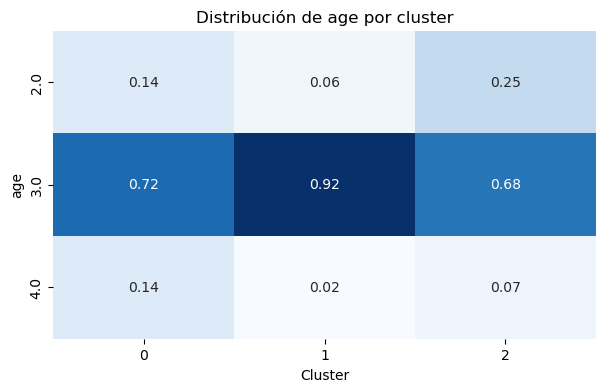

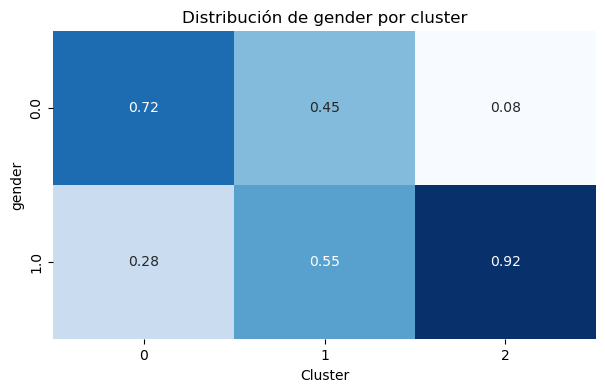

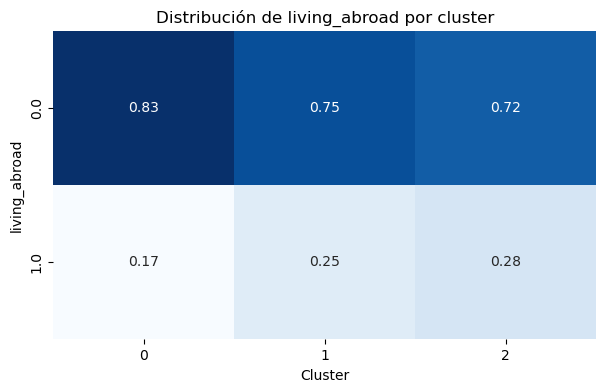

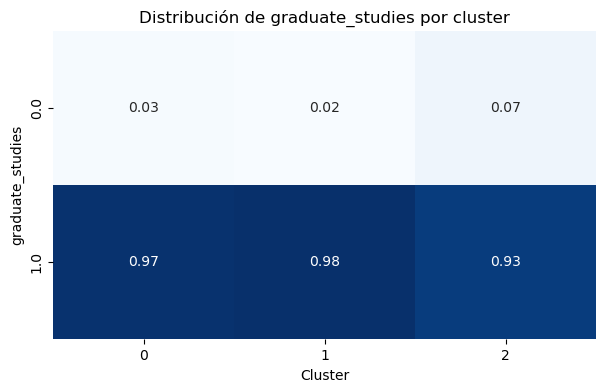

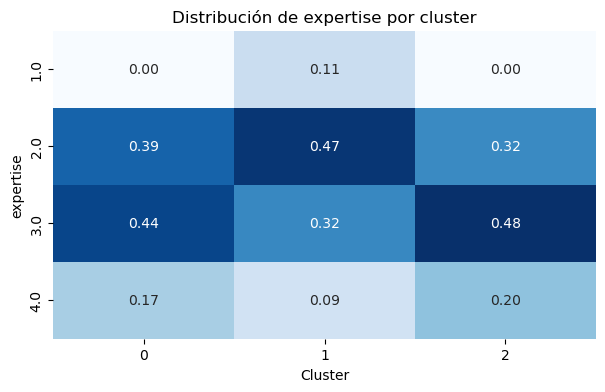

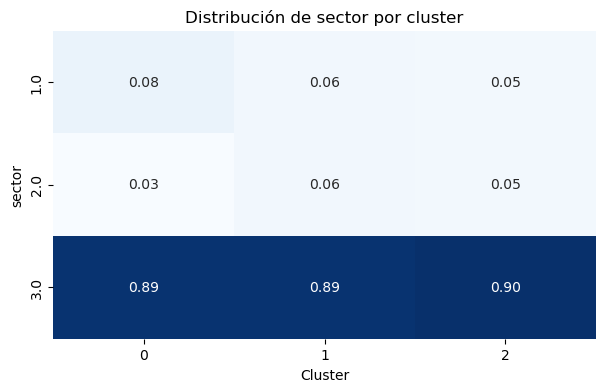

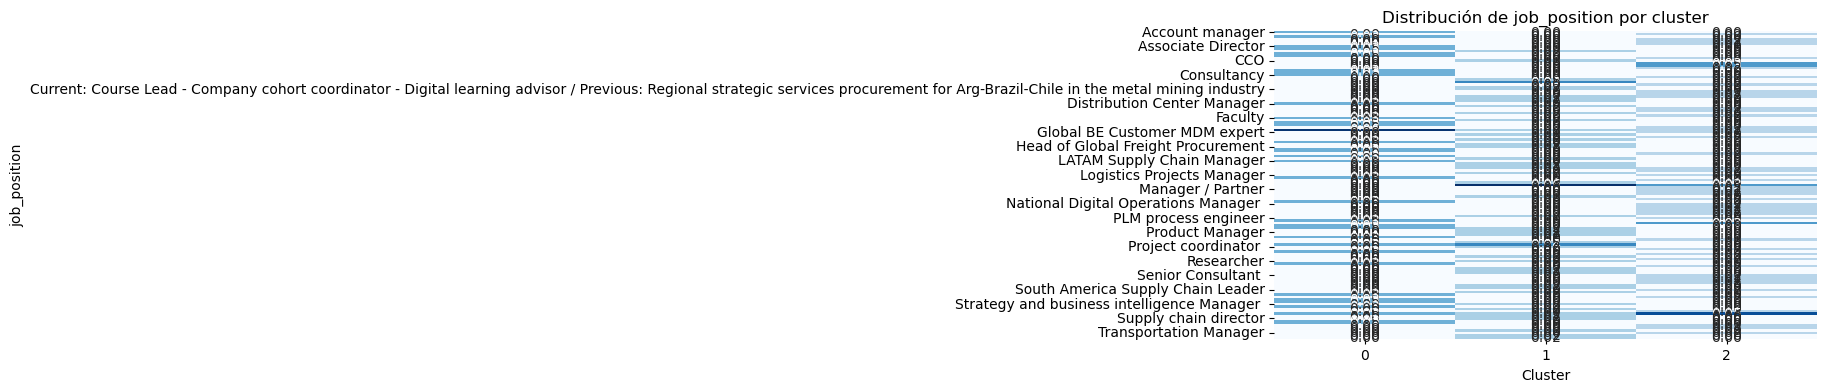

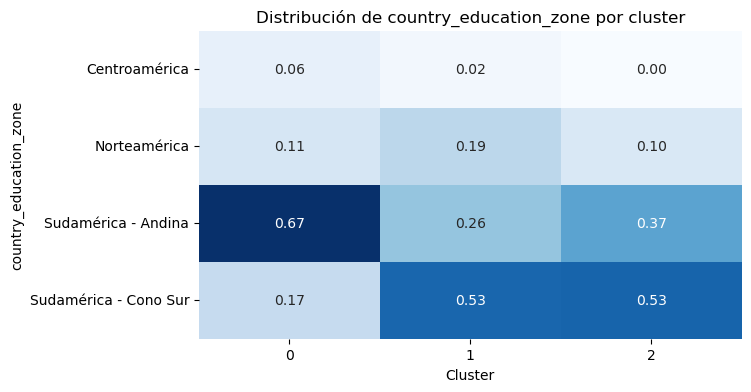

In [252]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Variables categóricas a explorar
cat_cols = ["age","gender","living_abroad","graduate_studies",
            "expertise","sector","job_position","country_education_zone"]

cluster_col = "cluster_only_skills"

# 1) Tablas de contingencia + Chi2
for c in cat_cols:
    if c in df_mixed.columns:
        ct = pd.crosstab(df_mixed[c], df_mixed[cluster_col])
        chi2, p, dof, exp = chi2_contingency(ct)
        print(f"\n=== {c} ===")
        print("Tabla de contingencia:\n", ct)
        print("Proporciones por cluster:\n", ct.div(ct.sum(axis=0), axis=1).round(2))
        print(f"Chi2={chi2:.2f}, p={p:.4f}")

# 2) Visualización: heatmap de proporciones
for c in cat_cols:
    if c in df_mixed.columns:
        ct = pd.crosstab(df_mixed[c], df_mixed[cluster_col], normalize="columns")
        plt.figure(figsize=(7,4))
        sns.heatmap(ct, annot=True, cmap="Blues", cbar=False, fmt=".2f")
        plt.title(f"Distribución de {c} por cluster")
        plt.ylabel(c)
        plt.xlabel("Cluster")
        plt.show()


In [258]:
import pandas as pd
from scipy.stats import chi2_contingency

# Variables categóricas a probar
cat_cols = ["age","gender","living_abroad","graduate_studies",
            "expertise","sector","job_position","country_education_zone"]

cluster_col = "cluster_only_skills"

resumen = []

for c in cat_cols:
    if c in df_mixed.columns:
        ct = pd.crosstab(df_mixed[c], df_mixed[cluster_col])
        chi2, p, dof, exp = chi2_contingency(ct)
        resumen.append({
            "Variable": c,
            "Chi2": chi2,
            "p_value": p,
            "dof": dof
        })

# Ordenamos por p-value ascendente
resumen_df = pd.DataFrame(resumen).sort_values("p_value").reset_index(drop=True)

print("=== Resumen de asociación categóricas vs cluster_only_skills ===")
print(resumen_df)

# Opcional: quedarnos con las top 3 más asociadas
top3 = resumen_df.head(3)
print("\nTop 3 categóricas más asociadas con los clusters:")
print(top3)


=== Resumen de asociación categóricas vs cluster_only_skills ===
                 Variable        Chi2       p_value  dof
0                  gender   41.912892  7.920107e-10    2
1  country_education_zone   22.424495  1.014019e-03    6
2                     age   13.790190  7.995685e-03    4
3               expertise   16.566602  1.101522e-02    6
4            job_position  261.593136  3.917267e-01  256
5        graduate_studies    1.855301  3.954819e-01    2
6           living_abroad    1.677405  4.322710e-01    2
7                  sector    0.838464  9.332183e-01    4

Top 3 categóricas más asociadas con los clusters:
                 Variable       Chi2       p_value  dof
0                  gender  41.912892  7.920107e-10    2
1  country_education_zone  22.424495  1.014019e-03    6
2                     age  13.790190  7.995685e-03    4


gender                    0.0       1.0
cluster_only_skills                    
0                    0.722222  0.277778
1                    0.452830  0.547170
2                    0.083333  0.916667


<Axes: xlabel='cluster_only_skills'>

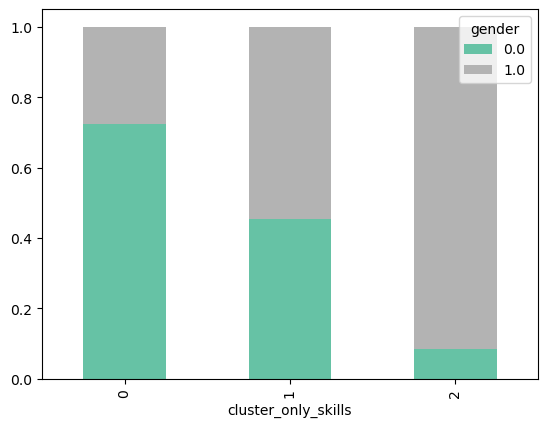

In [276]:
# Aunque los clusters fueron construidos solo con las variables de skills (personal_skills, technical_skills, teamwork_skills), resulta que se alinean fuertemente con género
tab = pd.crosstab(df_mixed["cluster_only_skills"], df_mixed["gender"], normalize="index")
print(tab)

# 0 = mujer   1=hombre
tab.plot(kind="bar", stacked=True, colormap="Set2")



=== country_education_zone ===
country_education_zone  Centroamérica  Norteamérica  Sudamérica - Andina  \
cluster_only_skills                                                        
0                                0.06          0.11                 0.67   
1                                0.02          0.19                 0.26   
2                                0.00          0.10                 0.37   

country_education_zone  Sudamérica - Cono Sur  
cluster_only_skills                            
0                                        0.17  
1                                        0.53  
2                                        0.53  


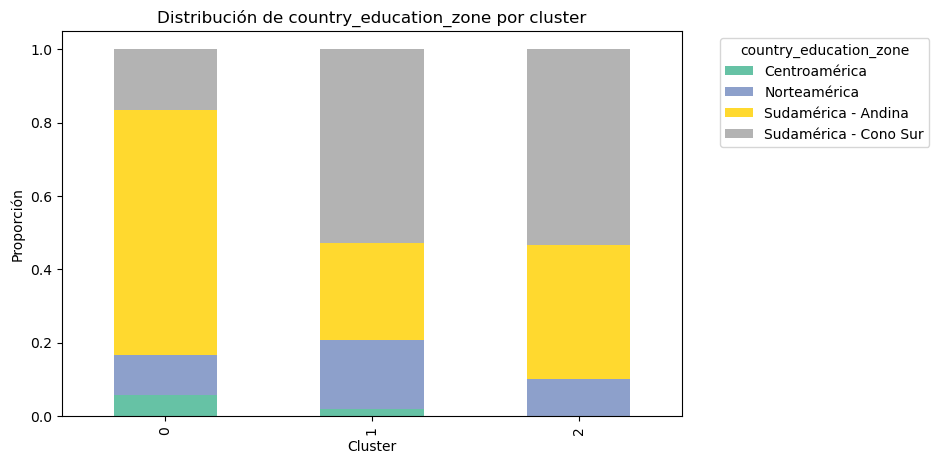


=== age ===
age                   2.0   3.0   4.0
cluster_only_skills                  
0                    0.14  0.72  0.14
1                    0.06  0.92  0.02
2                    0.25  0.68  0.07


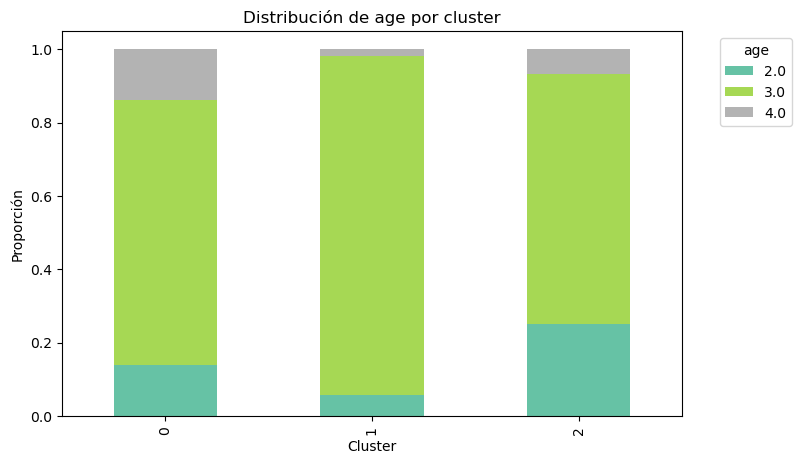

In [282]:
import matplotlib.pyplot as plt

cluster_col = "cluster_only_skills"

for var in ["country_education_zone", "age"]:
    if var in df_mixed.columns:
        print(f"\n=== {var} ===")
        
        # Tabla de proporciones normalizadas por cluster
        tab = pd.crosstab(df_mixed[cluster_col], df_mixed[var], normalize="index")
        print(tab.round(2))  # imprime porcentajes
        
        # Gráfico de barras apiladas
        tab.plot(kind="bar", stacked=True, figsize=(8,5), colormap="Set2")
        plt.title(f"Distribución de {var} por cluster")
        plt.ylabel("Proporción")
        plt.xlabel("Cluster")
        plt.legend(title=var, bbox_to_anchor=(1.05,1), loc="upper left")
        plt.show()


<Figure size 700x400 with 0 Axes>

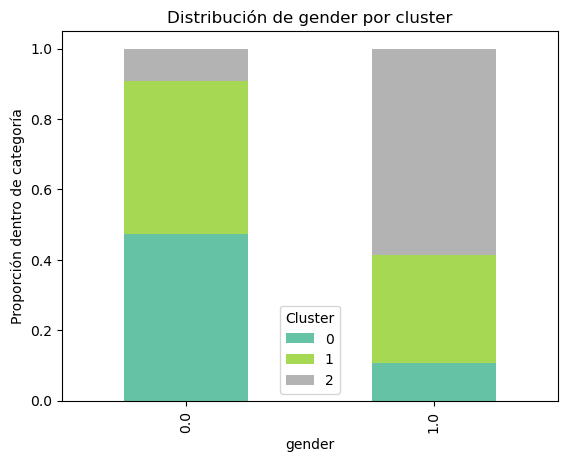

<Figure size 700x400 with 0 Axes>

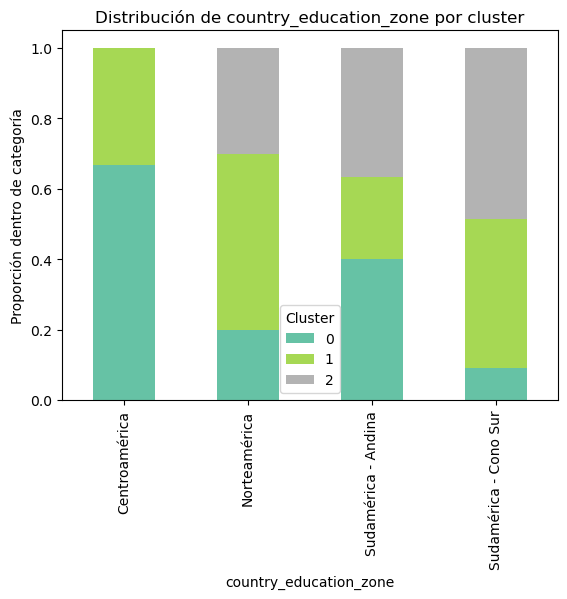

<Figure size 700x400 with 0 Axes>

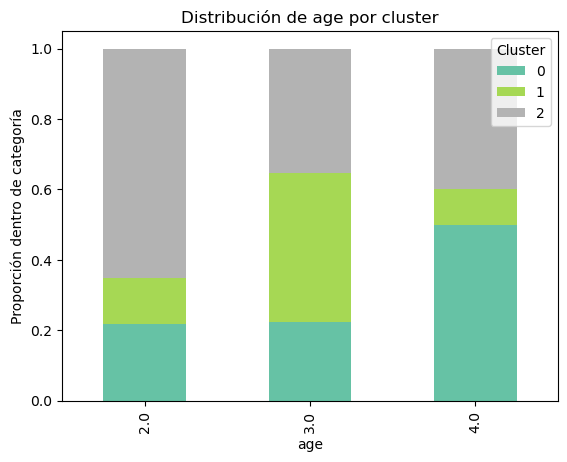

In [260]:
import seaborn as sns
import matplotlib.pyplot as plt

top_vars = ["gender","country_education_zone","age"]
cluster_col = "cluster_only_skills"

for var in top_vars:
    plt.figure(figsize=(7,4))
    ct = pd.crosstab(df_mixed[var], df_mixed[cluster_col], normalize="index")
    ct.plot(kind="bar", stacked=True, colormap="Set2")
    plt.title(f"Distribución de {var} por cluster")
    plt.ylabel("Proporción dentro de categoría")
    plt.xlabel(var)
    plt.legend(title="Cluster")
    plt.show()


In [286]:
import pandas as pd
from scipy.stats import chi2_contingency

# Variables categóricas a probar
cat_cols = ["age","gender","living_abroad","graduate_studies",
            "expertise","sector","job_position","country_education_zone"]

cluster_col = "cluster"

resumen = []

for c in cat_cols:
    if c in df_mixed.columns:
        ct = pd.crosstab(df_mixed[c], df_mixed[cluster_col])
        chi2, p, dof, exp = chi2_contingency(ct)
        resumen.append({
            "Variable": c,
            "Chi2": chi2,
            "p_value": p,
            "dof": dof
        })

# Ordenamos por p-value ascendente
resumen_df = pd.DataFrame(resumen).sort_values("p_value").reset_index(drop=True)

print("=== Resumen de asociación categóricas vs cluster ===")
print(resumen_df)

# Opcional: quedarnos con las top 3 más asociadas
top3 = resumen_df.head(3)
print("\nTop 3 categóricas más asociadas con los clusters:")
print(top3)


=== Resumen de asociación categóricas vs cluster ===
                 Variable        Chi2   p_value  dof
0               expertise   23.772372  0.021840   12
1                  gender   10.731713  0.029751    4
2           living_abroad    8.033771  0.090349    4
3                     age   10.796256  0.213513    8
4            job_position  532.790478  0.254025  512
5  country_education_zone   10.445611  0.576929   12
6        graduate_studies    1.245999  0.870469    4
7                  sector    1.725966  0.988292    8

Top 3 categóricas más asociadas con los clusters:
        Variable       Chi2   p_value  dof
0      expertise  23.772372  0.021840   12
1         gender  10.731713  0.029751    4
2  living_abroad   8.033771  0.090349    4


In [294]:
df_mixed.cluster.value_counts()

cluster
3    46
1    42
0    33
4    25
2     3
Name: count, dtype: int64

Distribución proporcional de expertise por cluster:

expertise   1.0   2.0   3.0   4.0
cluster                          
0          0.15  0.42  0.36  0.06
1          0.00  0.31  0.52  0.17
2          0.00  1.00  0.00  0.00
3          0.00  0.39  0.39  0.22
4          0.04  0.40  0.40  0.16


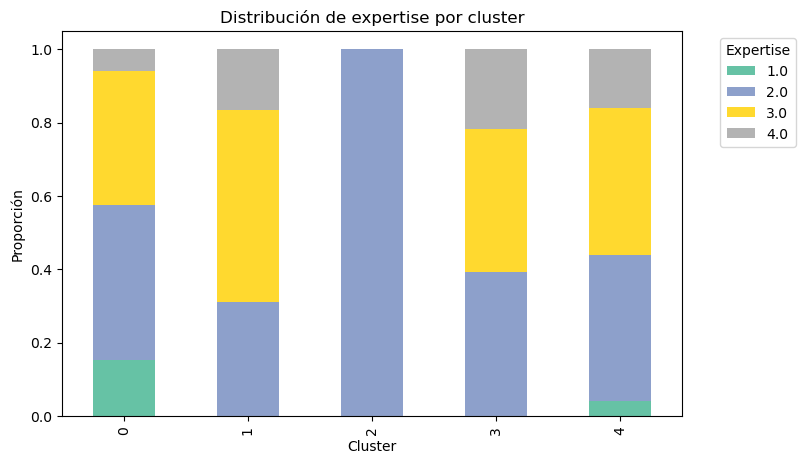

In [292]:
cluster_col = "cluster"
var = "expertise"

# Tabla de proporciones
tab = pd.crosstab(df_mixed[cluster_col], df_mixed[var], normalize="index")
print("Distribución proporcional de expertise por cluster:\n")
print(tab.round(2))

# Gráfico de barras apiladas
tab.plot(kind="bar", stacked=True, figsize=(8,5), colormap="Set2")
plt.title("Distribución de expertise por cluster")
plt.ylabel("Proporción")
plt.xlabel("Cluster")
plt.legend(title="Expertise", bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()

In [290]:
# Variables categóricas a probar
cat_cols = ["age","gender","living_abroad","graduate_studies",
            "expertise","sector","job_position","country_education_zone"]

cluster_col = "cluster_no_skills"

resumen = []

for c in cat_cols:
    if c in df_mixed.columns:
        ct = pd.crosstab(df_mixed[c], df_mixed[cluster_col])
        chi2, p, dof, exp = chi2_contingency(ct)
        resumen.append({
            "Variable": c,
            "Chi2": chi2,
            "p_value": p,
            "dof": dof
        })

# Ordenamos por p-value ascendente
resumen_df = pd.DataFrame(resumen).sort_values("p_value").reset_index(drop=True)

print("=== Resumen de asociación categóricas vs cluster_no_skills ===")
print(resumen_df)

# Opcional: quedarnos con las top 3 más asociadas
top3 = resumen_df.head(3)
print("\nTop 3 categóricas más asociadas con los clusters:")
print(top3)


=== Resumen de asociación categóricas vs cluster_no_skills ===
                 Variable        Chi2   p_value  dof
0               expertise   13.296512  0.038562    6
1           living_abroad    4.525038  0.104088    2
2            job_position  281.698553  0.129442  256
3  country_education_zone    5.069658  0.534911    6
4                     age    2.648719  0.618218    4
5                  gender    0.414116  0.812972    2
6        graduate_studies    0.337425  0.844752    2
7                  sector    1.235129  0.872282    4

Top 3 categóricas más asociadas con los clusters:
        Variable        Chi2   p_value  dof
0      expertise   13.296512  0.038562    6
1  living_abroad    4.525038  0.104088    2
2   job_position  281.698553  0.129442  256


In [298]:
df_mixed.cluster_no_skills.value_counts()

cluster_no_skills
1    86
0    60
2     3
Name: count, dtype: int64

Distribución proporcional de expertise por cluster:

expertise           1.0   2.0   3.0   4.0
cluster_no_skills                        
0                  0.00  0.38  0.38  0.23
1                  0.07  0.37  0.45  0.10
2                  0.00  1.00  0.00  0.00


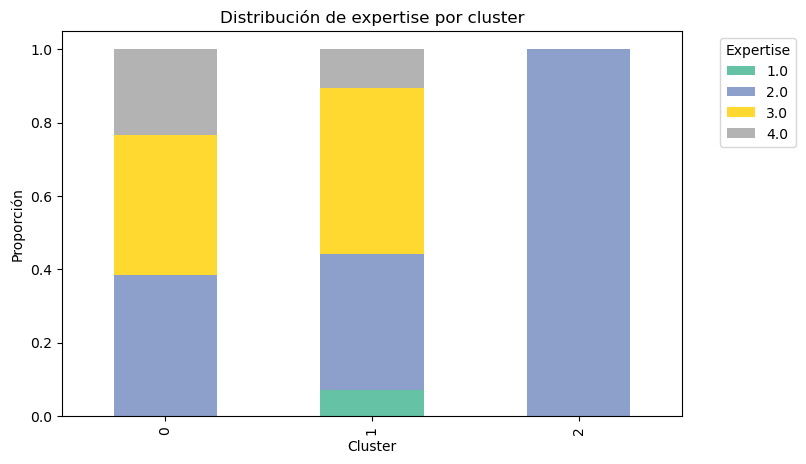

In [296]:
cluster_col = "cluster_no_skills"
var = "expertise"

# Tabla de proporciones
tab = pd.crosstab(df_mixed[cluster_col], df_mixed[var], normalize="index")
print("Distribución proporcional de expertise por cluster:\n")
print(tab.round(2))

# Gráfico de barras apiladas
tab.plot(kind="bar", stacked=True, figsize=(8,5), colormap="Set2")
plt.title("Distribución de expertise por cluster")
plt.ylabel("Proporción")
plt.xlabel("Cluster")
plt.legend(title="Expertise", bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()

In [302]:
df_mixed[df_mixed.cluster_no_skills == 2]

,age,gender,living_abroad,graduate_studies,expertise,sector,job_position,country_education_zone,1.1. Awareness of the needs of others,1.2. Integrity,...,3.7. E-business and enabling technology,3.8. Continuity and contingency planning,personal_skills,technical_skills,teamwork_skills,cluster,cluster_all,cluster_no_skills,cluster_only_skills,gender_num
11,3.0,1.0,0.0,1.0,2.0,3.0,SR SCM Manager LATAM,Sudamérica - Cono Sur,4.0,3.0,...,1.0,3.0,3.142857,2.375,3.125,2,1,2,1,NaN
23,3.0,1.0,0.0,1.0,2.0,3.0,Manufacturing Operations and Engineering Manager,Norteamérica,3.0,5.0,...,4.0,2.0,3.428571,1.625,2.375,2,1,2,1,NaN
102,3.0,0.0,0.0,1.0,2.0,3.0,Supply Chain Coordinator,Sudamérica - Andina,2.0,3.0,...,2.0,3.0,2.857143,2.750,2.750,2,1,2,1,NaN


# Diferencia entre las varianzas

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

try:
    from scipy.stats import levene
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False



zona_col = None
for c in df.columns:
    if str(c).strip().lower() in ["zona", "region", "área", "area"]:
        zona_col = c
        break

In [122]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if zona_col in num_cols:
    num_cols.remove(zona_col)

if len(num_cols) == 0:
    raise ValueError("No se detectaron columnas numéricas de preguntas. Revisa tu CSV.")

In [124]:
df_num = df[num_cols]

# ========= 2) Métricas de homogeneidad global (todas las zonas juntas) =========
desc = pd.DataFrame({
    "varianza": df_num.var(numeric_only=True, ddof=1),
    "desv_estandar": df_num.std(numeric_only=True, ddof=1),
    "media": df_num.mean(numeric_only=True)
}).sort_values("varianza", ascending=True)

In [126]:
desc["cv"] = desc["desv_estandar"] / desc["media"].replace(0, np.nan).abs()
# Cuando media≈0, el CV puede ser engañoso; marcamos esos casos:
desc["cv_flag_media_casi_cero"] = desc["media"].abs() < 1e-6

print("\n=== Resumen global de homogeneidad por pregunta (ordenado de menor a mayor varianza) ===")
print(desc.round(4).head(20))
print("\nPreguntas con mayor varianza (menos homogéneas):")
print(desc.round(4).tail(10))


=== Resumen global de homogeneidad por pregunta (ordenado de menor a mayor varianza) ===
                                                varianza  desv_estandar  \
personal_skills                                   0.1639         0.4049   
teamwork_skills                                   0.2134         0.4620   
technical_skills                                  0.2706         0.5202   
1.2. Integrity                                    0.2859         0.5347   
3.1. Problem-solving and decision-making          0.3461         0.5883   
3.2. Teamwork                                     0.3714         0.6094   
1.1. Awareness of the needs of others             0.3724         0.6102   
1.3. Continuous learning                          0.3998         0.6323   
1.5. Interpersonal skills                         0.4214         0.6491   
3.5. Planning and organizing                      0.4435         0.6660   
1.4. Effective communication                      0.4518         0.6722   
2.4. Suppl

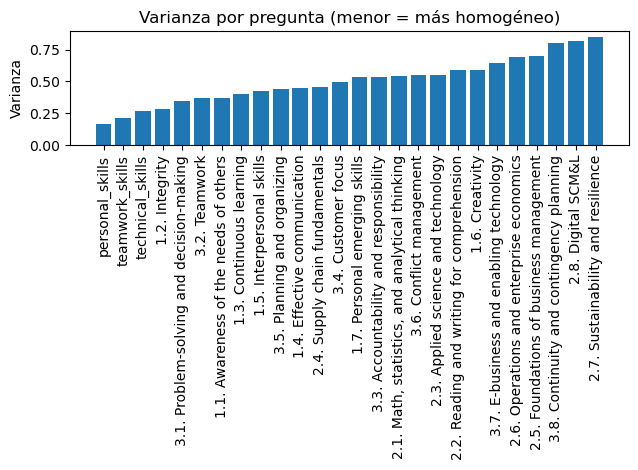

In [128]:
orden_var = desc.sort_values("varianza", ascending=True)
plt.figure()
plt.bar(range(len(orden_var)), orden_var["varianza"].values)
plt.xticks(range(len(orden_var)), orden_var.index, rotation=90)
plt.ylabel("Varianza")
plt.title("Varianza por pregunta (menor = más homogéneo)")
plt.tight_layout()
plt.show()

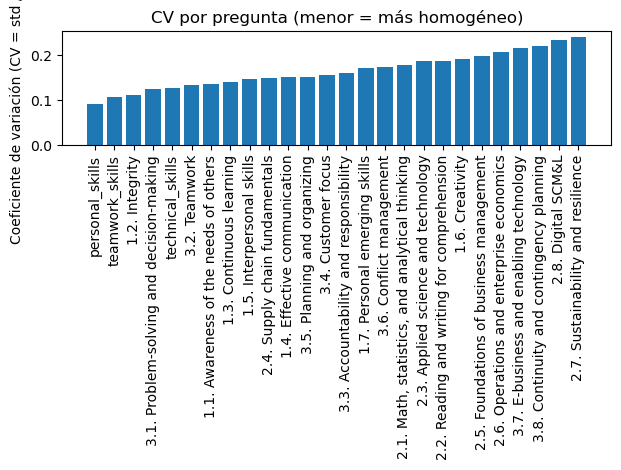

In [129]:
orden_cv = desc.sort_values("cv", ascending=True)
plt.figure()
plt.bar(range(len(orden_cv)), orden_cv["cv"].replace([np.inf, -np.inf], np.nan).fillna(np.nan).values)
plt.xticks(range(len(orden_cv)), orden_cv.index, rotation=90)
plt.ylabel("Coeficiente de variación (CV = std / |media|)")
plt.title("CV por pregunta (menor = más homogéneo)")
plt.tight_layout()
plt.show()

In [132]:
v = desc["varianza"].values.astype(float)
if np.nanmax(v) > np.nanmin(v):
    v_norm = (v - np.nanmin(v)) / (np.nanmax(v) - np.nanmin(v))
    indice_h = 1 - v_norm
    desc["indice_homogeneidad_0a1"] = indice_h
    print("\nÍndice de homogeneidad (0 a 1, mayor = más homogéneo):")
    print(desc.sort_values("indice_homogeneidad_0a1", ascending=False).round(4).head(20))


Índice de homogeneidad (0 a 1, mayor = más homogéneo):
                                                varianza  desv_estandar  \
personal_skills                                   0.1639         0.4049   
teamwork_skills                                   0.2134         0.4620   
technical_skills                                  0.2706         0.5202   
1.2. Integrity                                    0.2859         0.5347   
3.1. Problem-solving and decision-making          0.3461         0.5883   
3.2. Teamwork                                     0.3714         0.6094   
1.1. Awareness of the needs of others             0.3724         0.6102   
1.3. Continuous learning                          0.3998         0.6323   
1.5. Interpersonal skills                         0.4214         0.6491   
3.5. Planning and organizing                      0.4435         0.6660   
1.4. Effective communication                      0.4518         0.6722   
2.4. Supply chain fundamentals              

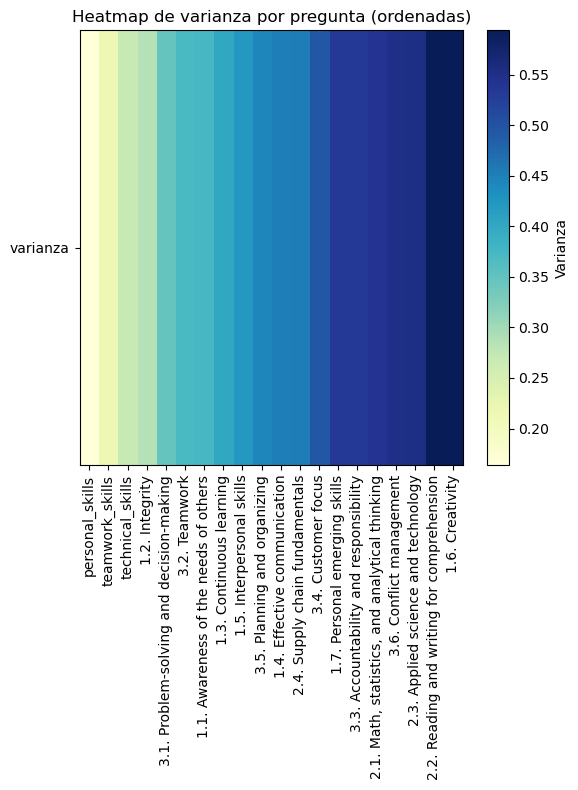

In [134]:
import pandas as pd
import matplotlib.pyplot as plt

# === Datos de ejemplo (puedes sustituirlos por tus varianzas calculadas) ===
data = {
    "varianza": {
        "personal_skills": 0.1639,
        "teamwork_skills": 0.2134,
        "technical_skills": 0.2706,
        "1.2. Integrity": 0.2859,
        "3.1. Problem-solving and decision-making": 0.3461,
        "3.2. Teamwork": 0.3714,
        "1.1. Awareness of the needs of others": 0.3724,
        "1.3. Continuous learning": 0.3998,
        "1.5. Interpersonal skills": 0.4214,
        "3.5. Planning and organizing": 0.4435,
        "1.4. Effective communication": 0.4518,
        "2.4. Supply chain fundamentals": 0.4538,
        "3.4. Customer focus": 0.4946,
        "1.7. Personal emerging skills": 0.5324,
        "3.3. Accountability and responsibility": 0.5349,
        "2.1. Math, statistics, and analytical thinking": 0.5408,
        "3.6. Conflict management": 0.5493,
        "2.3. Applied science and technology": 0.5533,
        "2.2. Reading and writing for comprehension": 0.5937,
        "1.6. Creativity": 0.5939,
    }
}

df_var = pd.DataFrame(data)

# === Ordenar de menor a mayor varianza ===
df_var_sorted = df_var.sort_values("varianza", ascending=True)

# === Heatmap con matplotlib ===
plt.figure(figsize=(6, 8))
plt.imshow(df_var_sorted.T, cmap="YlGnBu", aspect="auto")

# Barra de color
plt.colorbar(label="Varianza")

# Etiquetas en los ejes
plt.yticks([0], ["varianza"])
plt.xticks(range(len(df_var_sorted.index)), df_var_sorted.index, rotation=90)

plt.title("Heatmap de varianza por pregunta (ordenadas)")
plt.tight_layout()
plt.show()


# Sin demográficos

In [1]:
import pandas as pd
df = pd.read_csv("encuesta_limpia.csv")
df = df.drop(columns = "Unnamed: 0")
df = df.drop(columns= ['PC1', 'PC2', 'cluster'])

In [3]:
df.columns

Index(['age', 'gender', 'country', 'city', 'country_education',
       'living_abroad', 'outside_latam', 'category_studies',
       'graduate_studies', 'expertise', 'sector', 'job_position', 'experience',
       '1.1. Awareness of the needs of others', '1.2. Integrity',
       '1.3. Continuous learning', '1.4. Effective communication',
       '1.5. Interpersonal skills', '1.6. Creativity',
       '1.7. Personal emerging skills',
       '2.1. Math, statistics, and analytical thinking',
       '2.2. Reading and writing for comprehension',
       '2.3. Applied science and technology', '2.4. Supply chain fundamentals',
       '2.5. Foundations of business management',
       '2.6. Operations and enterprise economics',
       '2.7. Sustainability and resilience', '2.8. Digital SCM&L',
       '3.1. Problem-solving and decision-making', '3.2. Teamwork',
       '3.3. Accountability and responsibility', '3.4. Customer focus',
       '3.5. Planning and organizing', '3.6. Conflict management',
  

In [5]:
data = df[['1.1. Awareness of the needs of others', '1.2. Integrity',
       '1.3. Continuous learning', '1.4. Effective communication',
       '1.5. Interpersonal skills', '1.6. Creativity',
       '1.7. Personal emerging skills',
       '2.1. Math, statistics, and analytical thinking',
       '2.2. Reading and writing for comprehension',
       '2.3. Applied science and technology', '2.4. Supply chain fundamentals',
       '2.5. Foundations of business management',
       '2.6. Operations and enterprise economics',
       '2.7. Sustainability and resilience', '2.8. Digital SCM&L',
       '3.1. Problem-solving and decision-making', '3.2. Teamwork',
       '3.3. Accountability and responsibility', '3.4. Customer focus',
       '3.5. Planning and organizing', '3.6. Conflict management',
       '3.7. E-business and enabling technology',
       '3.8. Continuity and contingency planning']]

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

In [8]:
corr_pearson  = data.corr(method='pearson')
corr_spearman = data.corr(method='spearman')

In [11]:
pairs = (
    corr_spearman.stack()
    .reset_index()
    .rename(columns={'level_0': 'var1', 'level_1': 'var2', 0: 'spearman_corr'})
)

pairs = pairs[pairs['var1'] < pairs['var2']]  # asegura no repetir pares
pairs_sorted = pairs.sort_values('spearman_corr', ascending=False)


top5 = pairs_sorted.head(25)
bottom5 = pairs_sorted.tail(25)

In [13]:
print("=== Top 5 correlaciones más altas (Spearman) ===")
display(top5.style.background_gradient(cmap="Reds", subset=["spearman_corr"])
               .format({"spearman_corr": "{:.2f}"}))

print("=== Top 5 correlaciones más bajas (Spearman) ===")
display(bottom5.style.background_gradient(cmap="Blues", subset=["spearman_corr"])
                  .format({"spearman_corr": "{:.2f}"}))

=== Top 5 correlaciones más altas (Spearman) ===


,var1,var2,spearman_corr
265,2.5. Foundations of business management,2.6. Operations and enterprise economics,0.54
73,1.4. Effective communication,1.5. Interpersonal skills,0.49
343,2.8. Digital SCM&L,3.7. E-business and enabling technology,0.47
51,1.3. Continuous learning,1.6. Creativity,0.47
221,2.3. Applied science and technology,2.8. Digital SCM&L,0.45
242,2.4. Supply chain fundamentals,2.6. Operations and enterprise economics,0.45
108,1.5. Interpersonal skills,3.2. Teamwork,0.44
201,2.2. Reading and writing for comprehension,3.3. Accountability and responsibility,0.44
228,2.3. Applied science and technology,3.7. E-business and enabling technology,0.43
482,3.6. Conflict management,3.8. Continuity and contingency planning,0.43


=== Top 5 correlaciones más bajas (Spearman) ===


,var1,var2,spearman_corr
34,1.2. Integrity,2.5. Foundations of business management,0.12
99,1.5. Interpersonal skills,"2.1. Math, statistics, and analytical thinking",0.12
67,1.3. Continuous learning,3.7. E-business and enabling technology,0.12
205,2.2. Reading and writing for comprehension,3.7. E-business and enabling technology,0.12
43,1.2. Integrity,3.6. Conflict management,0.12
59,1.3. Continuous learning,2.7. Sustainability and resilience,0.12
206,2.2. Reading and writing for comprehension,3.8. Continuity and contingency planning,0.11
45,1.2. Integrity,3.8. Continuity and contingency planning,0.11
36,1.2. Integrity,2.7. Sustainability and resilience,0.11
101,1.5. Interpersonal skills,2.3. Applied science and technology,0.10


In [150]:
df["1.2. Integrity"].mean()

4.74496644295302

In [ ]:
#Hacer nueva tabla con distintas categorías y fuertemente relacionadas. Igual con misma categoría y bajamente relacionadas

#En donde no está la integridad

# 14 de noviembre

## Prueba de Hipótesis

In [227]:
df_mixed = df_mixed.reset_index(drop=True)
df_nuevas_skills = df_nuevas_skills.reset_index(drop=True)
df_nuevas_skills = df_nuevas_skills.rename({'personal_skills' : "personal_skills2" , 
                         'communication_skills': 'communication_skills2', 
                         'analytical_technical_skills': 'analytical_technical_skills2',
                         'teamwork_leadership_skills' : 'teamwork_leadership_skills2',
                         'digital_strategic_skills' : "digital_strategic_skills2" } , axis=1)


df_final = pd.concat([df_mixed, df_nuevas_skills], axis=1)


In [323]:
import pandas as pd
import scipy.stats as stats

# -------------------------------
# DEFINICIÓN DE VARIABLES POR CLUSTER
# -------------------------------

skills_vars = ['personal_skills', 'technical_skills', 'teamwork_skills']

# Todas las preguntas de la encuesta (1.x, 2.x, 3.x)
survey_vars = [
    '1.1. Awareness of the needs of others', '1.2. Integrity',
    '1.3. Continuous learning', '1.4. Effective communication',
    '1.5. Interpersonal skills', '1.6. Creativity',
    '1.7. Personal emerging skills',
    '2.1. Math, statistics, and analytical thinking',
    '2.2. Reading and writing for comprehension',
    '2.3. Applied science and technology', '2.4. Supply chain fundamentals',
    '2.5. Foundations of business management',
    '2.6. Operations and enterprise economics',
    '2.7. Sustainability and resilience', '2.8. Digital SCM&L',
    '3.1. Problem-solving and decision-making', '3.2. Teamwork',
    '3.3. Accountability and responsibility', '3.4. Customer focus',
    '3.5. Planning and organizing', '3.6. Conflict management',
    '3.7. E-business and enabling technology',
    '3.8. Continuity and contingency planning'
]

# Variables usadas por cluster
vars_cluster = {
    "cluster_all": survey_vars + skills_vars,
    "cluster_no_skills": survey_vars,
    "cluster_only_skills": skills_vars
}

clusters = ["cluster_all", "cluster_no_skills", "cluster_only_skills"]

# ---------------------------------------------------------
# Función de prueba de normalidad
# ---------------------------------------------------------
def check_normality(df, variable, cluster_col):
    groups = [g[variable].dropna() for _, g in df.groupby(cluster_col)]
    pvals = [stats.shapiro(g)[1] for g in groups]
    return all(p > 0.05 for p in pvals), pvals

# ---------------------------------------------------------
# Comparación de medias ANOVA / Kruskal
# ---------------------------------------------------------
def compare_means(df, variable, cluster_col):

    normal, normal_pvals = check_normality(df, variable, cluster_col)
    groups = [g[variable].dropna() for _, g in df.groupby(cluster_col)]

    if normal:
        stat, p = stats.f_oneway(*groups)
        test_used = "ANOVA"
    else:
        stat, p = stats.kruskal(*groups)
        test_used = "Kruskal-Wallis"

    return {
        "cluster": cluster_col,
        "variable": variable,
        "normality_pvals": normal_pvals,
        "is_normal": normal,
        "test_used": test_used,
        "statistic": stat,
        "p_value": p,
        "significant_(p<0.05)": p < 0.05
    }

# ---------------------------------------------------------
# Ejecutar análisis respetando variables de cada cluster
# ---------------------------------------------------------
results = []

for cl in clusters:
    for var in vars_cluster[cl]:
        results.append(compare_means(df_mixed, var, cl))

results_df = pd.DataFrame(results)


In [ ]:
#Si hacemos la comparación de kruskal, hacerla en los clusters y ver si entre ellos hay diferencias significativas


In [325]:
results_df

,cluster,variable,normality_pvals,is_normal,test_used,statistic,p_value,significant_(p<0.05)
0,cluster_all,1.1. Awareness of the needs of others,"[3.3409462544810947e-11, 1.5154472838016555e-0...",False,Kruskal-Wallis,23.693590,7.161473e-06,True
1,cluster_all,1.2. Integrity,"[9.400194615520928e-15, 5.604845507142809e-06,...",False,Kruskal-Wallis,13.786241,1.014742e-03,True
2,cluster_all,1.3. Continuous learning,"[5.846350967058975e-13, 1.931187605381444e-05,...",False,Kruskal-Wallis,28.247651,7.346838e-07,True
3,cluster_all,1.4. Effective communication,"[1.748029349503716e-13, 0.0015239676424116681,...",False,Kruskal-Wallis,40.410160,1.678979e-09,True
4,cluster_all,1.5. Interpersonal skills,"[2.4946297850224726e-12, 6.643845233356061e-05...",False,Kruskal-Wallis,36.662508,1.093547e-08,True
5,cluster_all,1.6. Creativity,"[4.844161494799815e-09, 0.0021249693389604357,...",False,Kruskal-Wallis,32.297149,9.699810e-08,True
6,cluster_all,1.7. Personal emerging skills,"[4.294579958833911e-12, 0.0010509400295318004,...",False,Kruskal-Wallis,46.991542,6.250521e-11,True
7,cluster_all,"2.1. Math, statistics, and analytical thinking","[3.3674177626492083e-09, 0.0011863078070406758...",False,Kruskal-Wallis,20.963800,2.803939e-05,True
8,cluster_all,2.2. Reading and writing for comprehension,"[8.88840892701768e-10, 2.0724631737481514e-06,...",False,Kruskal-Wallis,45.180855,1.545617e-10,True
9,cluster_all,2.3. Applied science and technology,"[1.791787042339296e-08, 6.285109444862055e-06,...",False,Kruskal-Wallis,30.289092,2.647324e-07,True


In [327]:
df_mixed.groupby("cluster_only_skills")[skills_vars].mean()


,personal_skills,technical_skills,teamwork_skills
cluster_only_skills,,,
0,4.793651,4.454861,4.722222
1,4.061995,3.587264,3.912736
2,4.480952,4.281250,4.454167


In [336]:
means = df_mixed.groupby("cluster_all")[survey_vars + skills_vars].mean()

# Encontrar top 5 para cada cluster
top_features = means.apply(lambda row: row.nlargest(5).index.tolist(), axis=1)

# Mostrar de forma clara
for cluster_label, features in top_features.items():
    print("\n" + "="*60)
    print(f"🟦  TOP VARIABLES DEL CLUSTER {cluster_label}")
    print("="*60)
    for i, var in enumerate(features, start=1):
        print(f"{i}. {var}")



🟦  TOP VARIABLES DEL CLUSTER 0
1. 3.1. Problem-solving and decision-making
2. 1.2. Integrity
3. 3.3. Accountability and responsibility
4. 3.4. Customer focus
5. 1.4. Effective communication

🟦  TOP VARIABLES DEL CLUSTER 1
1. 1.2. Integrity
2. 1.3. Continuous learning
3. 2.4. Supply chain fundamentals
4. 1.1. Awareness of the needs of others
5. 3.1. Problem-solving and decision-making

🟦  TOP VARIABLES DEL CLUSTER 2
1. 1.2. Integrity
2. 3.1. Problem-solving and decision-making
3. 3.3. Accountability and responsibility
4. 3.2. Teamwork
5. 1.1. Awareness of the needs of others


In [329]:
df_mixed.groupby("cluster_all")[survey_vars + skills_vars].mean()


,1.1. Awareness of the needs of others,1.2. Integrity,1.3. Continuous learning,1.4. Effective communication,1.5. Interpersonal skills,1.6. Creativity,1.7. Personal emerging skills,"2.1. Math, statistics, and analytical thinking",2.2. Reading and writing for comprehension,2.3. Applied science and technology,...,3.2. Teamwork,3.3. Accountability and responsibility,3.4. Customer focus,3.5. Planning and organizing,3.6. Conflict management,3.7. E-business and enabling technology,3.8. Continuity and contingency planning,personal_skills,technical_skills,teamwork_skills
cluster_all,,,,,,,,,,,,,,,,,,,,,
0,4.677966,4.898305,4.796610,4.830508,4.745763,4.423729,4.728814,4.474576,4.542373,4.355932,...,4.813559,4.847458,4.847458,4.745763,4.661017,4.135593,4.491525,4.728814,4.474576,4.690678
1,4.000000,4.392857,4.357143,3.857143,3.857143,3.428571,3.678571,3.821429,3.392857,3.464286,...,3.892857,3.678571,3.714286,3.785714,3.535714,3.178571,3.321429,3.938776,3.459821,3.638393
2,4.483871,4.758065,4.225806,4.354839,4.370968,3.919355,4.080645,3.967742,3.967742,3.838710,...,4.580645,4.596774,4.483871,4.338710,4.161290,3.580645,3.919355,4.313364,3.975806,4.290323


## Diagramas de radar

In [348]:
df_mixed.groupby("cluster_only_skills")[skills_vars].mean()

,personal_skills,technical_skills,teamwork_skills
cluster_only_skills,,,
0,4.793651,4.454861,4.722222
1,4.061995,3.587264,3.912736
2,4.480952,4.281250,4.454167


In [364]:
df_mixed.cluster_only_skills.value_counts()

cluster_only_skills
2    60
1    53
0    36
Name: count, dtype: int64

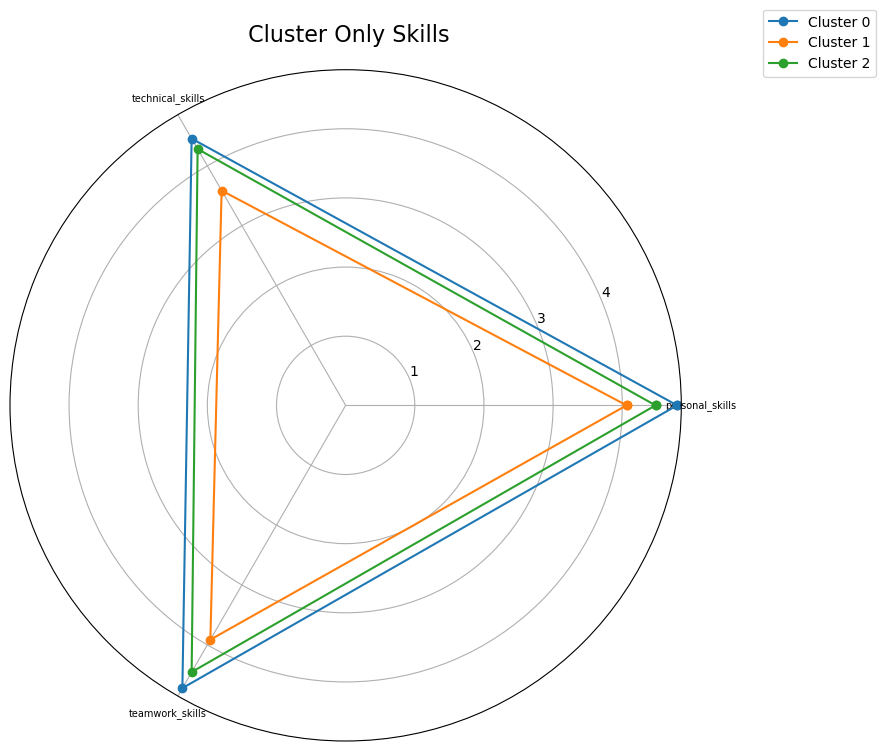

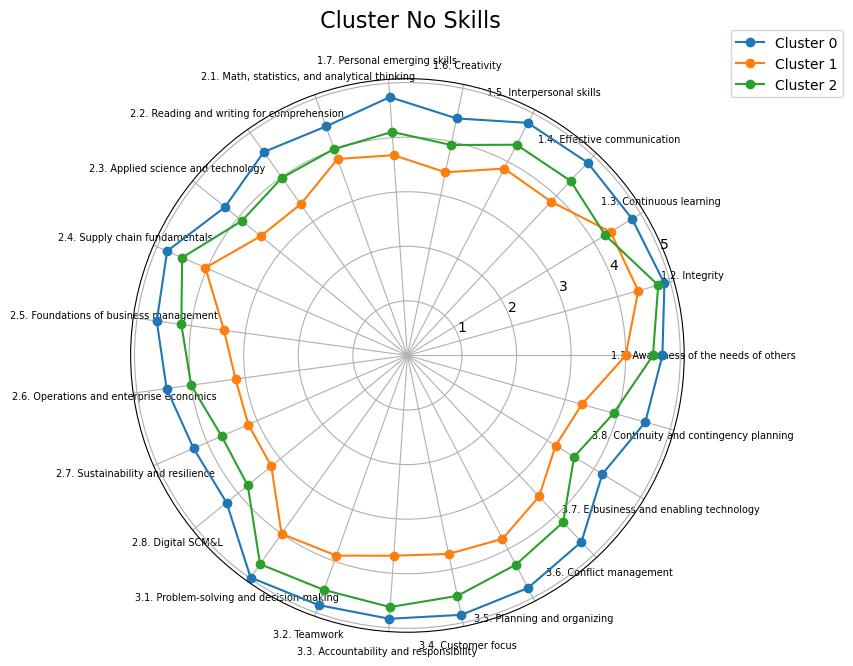

In [362]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --------------------------
# VARIABLES
# --------------------------

skills_vars = ['personal_skills', 'technical_skills', 'teamwork_skills']

survey_vars = [
    '1.1. Awareness of the needs of others', '1.2. Integrity',
    '1.3. Continuous learning', '1.4. Effective communication',
    '1.5. Interpersonal skills', '1.6. Creativity',
    '1.7. Personal emerging skills',
    '2.1. Math, statistics, and analytical thinking',
    '2.2. Reading and writing for comprehension',
    '2.3. Applied science and technology', '2.4. Supply chain fundamentals',
    '2.5. Foundations of business management',
    '2.6. Operations and enterprise economics',
    '2.7. Sustainability and resilience', '2.8. Digital SCM&L',
    '3.1. Problem-solving and decision-making', '3.2. Teamwork',
    '3.3. Accountability and responsibility', '3.4. Customer focus',
    '3.5. Planning and organizing', '3.6. Conflict management',
    '3.7. E-business and enabling technology',
    '3.8. Continuity and contingency planning'
]

# --------------------------
# FUNCIÓN GENERAL DE RADAR
# --------------------------

def radar_chart(df, cluster_col, variables, title):

    means = df.groupby(cluster_col)[variables].mean()
    clusters = means.index.tolist()

    num_vars = len(variables)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    plt.figure(figsize=(9, 9))

    for cl in clusters:
        vals = means.loc[cl].tolist()
        vals += vals[:1]

        plt.polar(angles, vals, marker='o', label=f"Cluster {cl}")

    plt.xticks(angles[:-1], variables, fontsize=7)
    plt.title(title, fontsize=16, pad=20)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()


# --------------------------
# RADAR: CLUSTER ONLY SKILLS
# --------------------------

radar_chart(
    df_mixed,
    cluster_col="cluster_only_skills",
    variables=skills_vars,
    title=" Cluster Only Skills"
)

# --------------------------
# RADAR: CLUSTER NO SKILLS
# --------------------------

radar_chart(
    df_mixed,
    cluster_col="cluster_no_skills",
    variables=survey_vars,
    title=" Cluster No Skills"
)


In [350]:
#Nuevas variables 5 skills
cluster_summary

,personal_skills,communication_skills,analytical_technical_skills,teamwork_leadership_skills,digital_strategic_skills
cluster_new_skills,,,,,
0,4.35,4.45,3.99,4.39,3.49
1,4.64,4.75,4.40,4.78,4.39
2,4.01,3.70,3.60,4.05,3.44
3,3.00,3.50,2.25,2.83,2.50


In [360]:
df_nuevas_skills.cluster_new_skills.value_counts()

cluster_new_skills
1    69
0    50
2    27
3     3
Name: count, dtype: int64

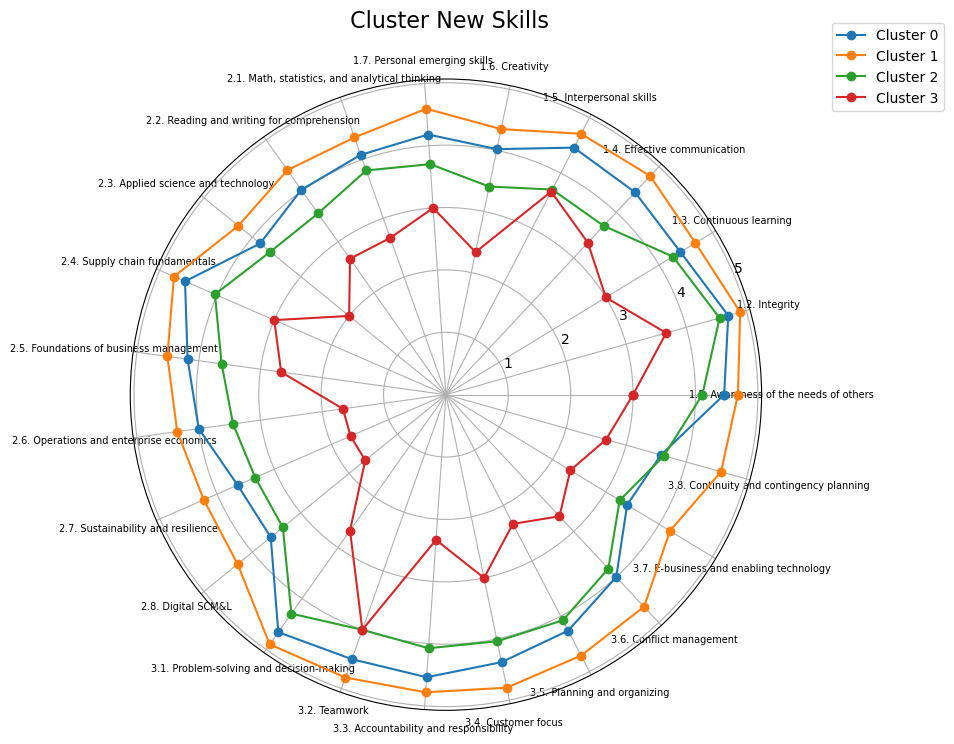

In [356]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------------
# VARIABLES DE LA ENCUESTA
# -------------------------------------
survey_vars = [
    '1.1. Awareness of the needs of others', '1.2. Integrity',
    '1.3. Continuous learning', '1.4. Effective communication',
    '1.5. Interpersonal skills', '1.6. Creativity',
    '1.7. Personal emerging skills',
    '2.1. Math, statistics, and analytical thinking',
    '2.2. Reading and writing for comprehension',
    '2.3. Applied science and technology', '2.4. Supply chain fundamentals',
    '2.5. Foundations of business management',
    '2.6. Operations and enterprise economics',
    '2.7. Sustainability and resilience', '2.8. Digital SCM&L',
    '3.1. Problem-solving and decision-making', '3.2. Teamwork',
    '3.3. Accountability and responsibility', '3.4. Customer focus',
    '3.5. Planning and organizing', '3.6. Conflict management',
    '3.7. E-business and enabling technology',
    '3.8. Continuity and contingency planning'
]

# -------------------------------------
# FUNCIÓN RADAR (misma que antes)
# -------------------------------------
def radar_chart(df, cluster_col, variables, title):

    means = df.groupby(cluster_col)[variables].mean()
    clusters = means.index.tolist()

    num_vars = len(variables)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    plt.figure(figsize=(10, 10))

    for cl in clusters:
        vals = means.loc[cl].tolist()
        vals += vals[:1]

        plt.polar(angles, vals, marker='o', label=f"Cluster {cl}")

    plt.xticks(angles[:-1], variables, fontsize=7)
    plt.title(title, fontsize=16, pad=20)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()


# -------------------------------------
# GRAFICAR RADAR DEL CLUSTER NEW SKILLS
# -------------------------------------
radar_chart(
    df_nuevas_skills,
    cluster_col="cluster_new_skills",
    variables=survey_vars,
    title=" Cluster New Skills"
)


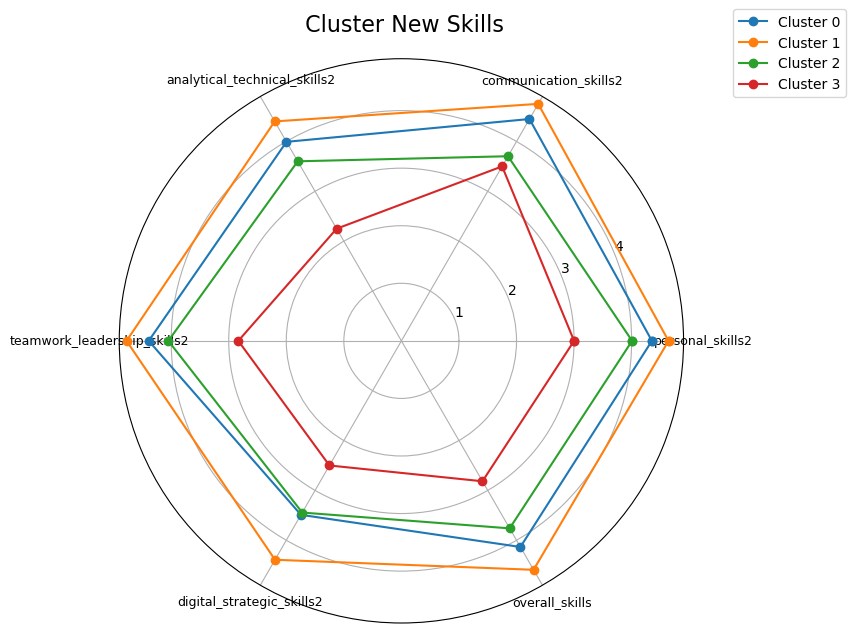

In [354]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------------
# VARIABLES QUE DEFINEN EL CLUSTER
# -------------------------------------
new_skills_vars = [
    'personal_skills2', 
    'communication_skills2', 
    'analytical_technical_skills2',
    'teamwork_leadership_skills2', 
    'digital_strategic_skills2',
    'overall_skills'
]

# -------------------------------------
# FUNCIÓN RADAR (misma que antes)
# -------------------------------------
def radar_chart(df, cluster_col, variables, title):

    means = df.groupby(cluster_col)[variables].mean()
    clusters = means.index.tolist()

    num_vars = len(variables)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    plt.figure(figsize=(9, 9))

    for cl in clusters:
        vals = means.loc[cl].tolist()
        vals += vals[:1]

        plt.polar(angles, vals, marker='o', label=f"Cluster {cl}")

    plt.xticks(angles[:-1], variables, fontsize=9)
    plt.title(title, fontsize=16, pad=20)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

# -------------------------------------
# GRAFICAR RADAR DEL CLUSTER NUEVO
# -------------------------------------
radar_chart(
    df_nuevas_skills,
    cluster_col="cluster_new_skills",
    variables=new_skills_vars,
    title=" Cluster New Skills"
)


In [342]:
df_nuevas_skills.columns

Index(['age', 'gender', 'living_abroad', 'graduate_studies', 'expertise',
       'sector', 'job_position', 'country_education_zone',
       '1.1. Awareness of the needs of others', '1.2. Integrity',
       '1.3. Continuous learning', '1.4. Effective communication',
       '1.5. Interpersonal skills', '1.6. Creativity',
       '1.7. Personal emerging skills',
       '2.1. Math, statistics, and analytical thinking',
       '2.2. Reading and writing for comprehension',
       '2.3. Applied science and technology', '2.4. Supply chain fundamentals',
       '2.5. Foundations of business management',
       '2.6. Operations and enterprise economics',
       '2.7. Sustainability and resilience', '2.8. Digital SCM&L',
       '3.1. Problem-solving and decision-making', '3.2. Teamwork',
       '3.3. Accountability and responsibility', '3.4. Customer focus',
       '3.5. Planning and organizing', '3.6. Conflict management',
       '3.7. E-business and enabling technology',
       '3.8. Continuity 

## Tabla de relaciones


In [21]:
df

,age,gender,country,city,country_education,living_abroad,outside_latam,category_studies,graduate_studies,expertise,...,3.2. Teamwork,3.3. Accountability and responsibility,3.4. Customer focus,3.5. Planning and organizing,3.6. Conflict management,3.7. E-business and enabling technology,3.8. Continuity and contingency planning,personal_skills,technical_skills,teamwork_skills
0,3.0,0.0,brazil,Sao Paulo,brazil,0.0,0.0,5.0,1.0,2.0,...,4.0,5.0,4.0,4.0,4.0,3.0,3.0,3.857143,3.750,3.875
1,3.0,1.0,brazil,Sao Paulo,brazil,0.0,0.0,5.0,1.0,2.0,...,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.571429,4.250,4.750
2,3.0,1.0,united states,Miami,argentina,1.0,1.0,5.0,1.0,2.0,...,3.0,4.0,4.0,4.0,3.0,3.0,4.0,4.571429,3.750,3.625
3,3.0,1.0,argentina,Buenos Aires,argentina,0.0,0.0,5.0,1.0,2.0,...,5.0,5.0,4.0,3.0,4.0,3.0,3.0,4.285714,3.625,3.875
4,3.0,1.0,brazil,Rio de Janeiro,brazil,0.0,0.0,5.0,1.0,3.0,...,4.0,4.0,3.0,4.0,3.0,3.0,3.0,3.857143,3.625,3.625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,2.0,1.0,mexico,Mexico City,mexico,0.0,0.0,5.0,1.0,4.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.000000,4.750,5.000
145,3.0,0.0,chile,Santiago,argentina,1.0,1.0,5.0,1.0,2.0,...,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.000000,4.875,4.875
146,3.0,0.0,brazil,Sao Paulo,brazil,0.0,0.0,5.0,1.0,3.0,...,4.0,5.0,3.0,5.0,4.0,3.0,3.0,4.285714,3.750,4.000
147,3.0,1.0,colombia,Bogota,colombia,0.0,0.0,5.0,1.0,3.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.000000,4.125,5.000


In [15]:
import pandas as pd


pairs_sorted["group1"] = pairs_sorted["var1"].str.split(".").str[0]
pairs_sorted["group2"] = pairs_sorted["var2"].str.split(".").str[0]


pairs_intergroups = pairs_sorted[pairs_sorted["group1"] != pairs_sorted["group2"]]


top15_intergroups = pairs_intergroups.head(15)


print("=== Top 15 correlaciones más altas ENTRE GRUPOS distintos (Spearman) ===")
display(
    top15_intergroups
    .style.background_gradient(cmap="Reds", subset=["spearman_corr"])
    .format({"spearman_corr": "{:.2f}"})
)


=== Top 15 correlaciones más altas ENTRE GRUPOS distintos (Spearman) ===


,var1,var2,spearman_corr,group1,group2
343,2.8. Digital SCM&L,3.7. E-business and enabling technology,0.47,2,3
108,1.5. Interpersonal skills,3.2. Teamwork,0.44,1,3
201,2.2. Reading and writing for comprehension,3.3. Accountability and responsibility,0.44,2,3
228,2.3. Applied science and technology,3.7. E-business and enabling technology,0.43,2,3
124,1.6. Creativity,2.3. Applied science and technology,0.42,1,2
100,1.5. Interpersonal skills,2.2. Reading and writing for comprehension,0.42,1,2
40,1.2. Integrity,3.3. Accountability and responsibility,0.41,1,3
291,2.6. Operations and enterprise economics,3.1. Problem-solving and decision-making,0.40,2,3
337,2.8. Digital SCM&L,3.1. Problem-solving and decision-making,0.39,2,3
293,2.6. Operations and enterprise economics,3.3. Accountability and responsibility,0.39,2,3


In [17]:
pairs_sorted["group1"] = pairs_sorted["var1"].str.split(".").str[0]
pairs_sorted["group2"] = pairs_sorted["var2"].str.split(".").str[0]

pairs_intragroups = pairs_sorted[pairs_sorted["group1"] == pairs_sorted["group2"]]


bottom15_intragroups = pairs_intragroups.tail(15)

print("=== Bottom 15 correlaciones MÁS BAJAS dentro del MISMO grupo (Spearman) ===")
display(
    bottom15_intragroups
    .style.background_gradient(cmap="Blues", subset=["spearman_corr"])
    .format({"spearman_corr": "{:.2f}"})
)


=== Bottom 15 correlaciones MÁS BAJAS dentro del MISMO grupo (Spearman) ===


,var1,var2,spearman_corr,group1,group2
1,1.1. Awareness of the needs of others,1.2. Integrity,0.19,1,1
29,1.2. Integrity,1.7. Personal emerging skills,0.19,1,1
97,1.5. Interpersonal skills,1.6. Creativity,0.19,1,1
49,1.3. Continuous learning,1.4. Effective communication,0.18,1,1
5,1.1. Awareness of the needs of others,1.6. Creativity,0.17,1,1
3,1.1. Awareness of the needs of others,1.4. Effective communication,0.15,1,1
266,2.5. Foundations of business management,2.7. Sustainability and resilience,0.15,2,2
413,3.3. Accountability and responsibility,3.8. Continuity and contingency planning,0.14,3,3
390,3.2. Teamwork,3.8. Continuity and contingency planning,0.14,3,3
458,3.5. Planning and organizing,3.7. E-business and enabling technology,0.14,3,3


In [ ]:
#Puede ser dificil ver que con los datos sea tan significante

In [23]:
import pandas as pd

# Variable objetivo
target = "1.2. Integrity"


corr_integrity = corr_spearman[target].drop(target)  # excluye la correlación consigo misma


corr_integrity_sorted = corr_integrity.sort_values(ascending=False)

print("=== Correlaciones Spearman con 1.2. Integrity ===")
display(
    corr_integrity_sorted.to_frame(name="spearman_corr")
    .style.background_gradient(cmap="RdYlGn", subset=["spearman_corr"])
    .format({"spearman_corr": "{:.2f}"})
)


=== Correlaciones Spearman con 1.2. Integrity ===


,spearman_corr
3.3. Accountability and responsibility,0.41
1.5. Interpersonal skills,0.32
3.4. Customer focus,0.23
1.4. Effective communication,0.21
2.2. Reading and writing for comprehension,0.20
1.1. Awareness of the needs of others,0.19
1.7. Personal emerging skills,0.19
3.2. Teamwork,0.19
3.7. E-business and enabling technology,0.14
1.6. Creativity,0.13


In [ ]:
#No hay relación con demográficos
#Hay clusters 4 en total contruir narrativa
#Hay habilidades correlacionadas, y hay habilidades que No
